In [1]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils import shuffle
from category_encoders import TargetEncoder, OneHotEncoder
import warnings
import pgeocode
import datetime
from math import radians
import joblib
import json
warnings.filterwarnings("ignore")
%matplotlib inline

# 1) Data Formatting

## Open Excel File in DataFrame

In [2]:
df = pd.read_excel('CarData.xlsx')

In [3]:
data = df.copy()

In [4]:
print(len(data.index))

62962


## Remove Incorrect Records

In [5]:
def find_incorrect_records(make, trim):
  if make in trim:
    return False
  return True

In [6]:
for i, row in data.iterrows():
  if find_incorrect_records(row['Make'], row['Trim']):
    data = data.drop(i)

## Remove Duplicates

In [7]:
data = data.drop_duplicates(subset=['VIN'])

In [8]:
data = data.drop('VIN', axis=1)

In [9]:
print(len(data.index))

61379


## Parse Column Information

In [10]:
def parse_year(car_string):
  match = re.search(r'\b(19|20)\d{2}\b', car_string)
  return int(match.group(0)) if match else None

def parse_trim(car_string, make, model):
  if make in car_string:
    trim = car_string.split(make, 1)[1]
    if model in trim:
      trim = trim.split(model, 1)[1]
      trim = trim.replace('for Sale', '')
      return str(trim.strip())
    else:
      return None
  else:
    return None

def parse_zip_code(location):
  if type(location) == str:
    zip = location.split(' ')[-1]
    return str(zip)
  return None

def parse_price(price):
  if type(price) == str:
    num = price.replace('$','')
    num = num.replace(',','')
    return int(num)
  return None

def parse_miles(miles):
  if type(miles) == str:
    mileage = miles.replace(' miles', '')
    mileage = mileage.replace(',','')
    return int(mileage.strip())
  return None

def parse_engine_size(engine):
  if type(engine) == str and '-cylinder' in engine:
    size = engine.replace('-cylinder','')
    return int(size.strip())
  return None

def parse_seats(seats):
  if type(seats) == str and 'seater' in seats:
    seats = seats.replace('seater','')
    return int(seats.strip())
  return None

In [11]:
data['Year'] = data['Year'].apply(parse_year)

data['Trim'] = data.apply(lambda row: parse_trim(row['Trim'], row['Make'], row['Model']), axis=1)

data['Location'] = data['Location'].apply(parse_zip_code)

data['Price'] = data['Price'].apply(parse_price)

data['Mileage'] = data['Mileage'].apply(parse_miles)

data['Engine_Size'] = data['Engine_Size'].apply(parse_engine_size)

data['Seats'] = data['Seats'].apply(parse_seats)

data.loc[data['Fuel_Type'] == 'Electric', 'Engine_Size'] = 0

data.loc[data['Fuel_Type'] == 'Natural Gas', 'Fuel_Type'] = 'Gas'

## Remove Some Null Values

In [12]:
len(data.index)

61379

In [13]:
data.sample(1)

,Make,Model,Year,Trim,Location,Price,Mileage,Transmission,Color,Engine_Size,Fuel_Type,Gas_Mileage,Seats,Drive_Type
16202,Dodge,Omni,1986,GLH,48026,23900.0,109550.0,Manual,Black,4.0,Gas,NaN,5.0,FWD


In [14]:
data = data.drop(data[data['Trim'].isna()].index)

In [15]:
data = data.drop(data[data['Trim']==''].index)

In [16]:
len(data.index)

59749

In [17]:
data.isna().sum().sum()

np.int64(28568)

## Replace Missing Engine Size

In [18]:
print("Engine Size: ", data['Engine_Size'].unique())

Engine Size:  [ 6.  4.  0. nan  8. 12.  5. 10.  3. 16.]


In [19]:
data['Engine_Size'].isna().sum()

np.int64(758)

In [20]:
def med_engine_size(model, year, trim, data, window=2):
  year_range = (year-window, year+window)
  relevant_data = data[(data['Model'] == model) & (data['Year'].between(year_range[0], year_range[1])) & (data['Trim'] == trim)]
  median_engine_size = relevant_data['Engine_Size'].median()
  return median_engine_size if not pd.isna(median_engine_size) else np.nan

In [21]:
def fill_nan_with_median(row):
  if pd.isna(row['Engine_Size']):
    return med_engine_size(row['Model'], row['Year'], row['Trim'], data)
  return row['Engine_Size']

In [22]:
data['Engine_Size'] = data.apply(fill_nan_with_median, axis=1)

In [23]:
data['Engine_Size'].isna().sum()

np.int64(624)

## Replace Missing Fuel Type

In [24]:
print("Fuel Type: ", data['Fuel_Type'].unique())

Fuel Type:  ['Gas' 'Hybrid' 'Electric' 'Plug-in Hybrid' 'Diesel' 'Flex fuel' nan]


In [25]:
data['Fuel_Type'].isna().sum()

np.int64(538)

In [26]:
def most_common_fuel_type(model, year, data, window=5):
  year_range = (year-window, year+window)
  relevant_data = data[(data['Model'] == model) & (data['Year'].between(year_range[0], year_range[1]))]
  common_fuel_type = relevant_data['Fuel_Type'].mode()
  return common_fuel_type[0] if not common_fuel_type.empty else np.nan

In [27]:
def fill_nan_with_fuel_type(row):
  if pd.isna(row['Fuel_Type']):
    return most_common_fuel_type(row['Model'], row['Year'], data)
  return row['Fuel_Type']

In [28]:
data['Fuel_Type'] = data.apply(fill_nan_with_fuel_type, axis=1)

In [29]:
data['Fuel_Type'].isna().sum()

np.int64(85)

## Replace Missing Transmission

In [30]:
print("Transmission: ", data['Transmission'].unique())

Transmission:  ['Automatic' 'Manual' 'CVT' 'Red' nan]


In [31]:
data = data[data['Transmission'] != 'Red']

In [32]:
data['Transmission'].isna().sum()

np.int64(1418)

In [33]:
def most_common_transmission(model, year, trim, data, window=5):
  year_range = (year-window, year+window)
  relevant_data = data[(data['Model'] == model) & (data['Year'].between(year_range[0], year_range[1])) & (data['Trim'] == trim)]
  common_transmission = relevant_data['Transmission'].mode()
  return common_transmission[0] if not common_transmission.empty else np.nan

In [34]:
def fill_nan_with_transmission(row):
  if pd.isna(row['Transmission']):
    return most_common_transmission(row['Model'], row['Year'], row['Trim'], data)
  return row['Transmission']

In [35]:
data['Transmission'] = data.apply(fill_nan_with_transmission, axis=1)

In [36]:
data['Transmission'].isna().sum()

np.int64(201)

## Replace Missing Gas Mileage

In [37]:
print("Gas Mileage: ", data['Gas_Mileage'].unique())

Gas Mileage:  [ 20.  21.  22.  28.  29.  25.  24.  32.  33.  30.  18.  19.  17.  nan
  23.  15.  27.  26.  87.  77.  13.  14.  16.  12.  34.  83.  31.  68.
  54.  78.  74.  79.  85.  82.  75.  95.  93. 100.  61.  50.  60.  81.
  73.  11.  47.  10.   9.  46.  67.  36.  71.  62.  65.  64. 124. 117.
 113. 111. 118.  96. 109. 120.  91. 105.  90.  76.  69.  86.  56.  89.
  88.  92. 115. 119.  35. 108.  98. 106.  94.  84.  44.  51. 112. 116.
  40.  41.  39. 102.  70.  66. 107.  97. 103.  42.  37.  99.  53.  48.
  43.  45. 110.  38.  52. 114. 121. 127.  55.  58.  59.  80.  49. 101.
 104. 123. 125. 122.  57.  63.]


In [38]:
data['Gas_Mileage'].isna().sum()

np.int64(12800)

In [39]:
def most_common_gas_mileage(model, year, trim, data, window=4):
  year_range = (year-window, year+window)
  relevant_data = data[(data['Model'] == model) & (data['Year'].between(year_range[0], year_range[1])) & (data['Trim'] == trim)]
  common_gas_mileage = relevant_data['Gas_Mileage'].mode()
  return common_gas_mileage[0] if not common_gas_mileage.empty else np.nan

In [40]:
def fill_nan_with_gas_mileage(row):
  if pd.isna(row['Gas_Mileage']):
    return most_common_gas_mileage(row['Model'], row['Year'], row['Trim'], data)
  return row['Gas_Mileage']

In [41]:
data['Gas_Mileage'] = data.apply(fill_nan_with_gas_mileage, axis=1)

In [42]:
data['Gas_Mileage'].isna().sum()

np.int64(8262)

## Replace Missing Drive Type

In [43]:
print("Drive Type: ", data['Drive_Type'].unique())

Drive Type:  ['FWD' 'AWD' 'RWD' 'FOUR_WD' nan '4 seater' 'FOUR_X_FOUR' '7 seater'
 'FOUR_X_TWO' 'JTJBC1BA4D2050855']


In [44]:
data = data.drop(data[data['Drive_Type'] == 'JTJBC1BA4D2050855'].index)
data = data.drop(data[data['Drive_Type'] == '4 seater'].index)
data = data.drop(data[data['Drive_Type'] == '7 seater'].index)
replacements = {
    'FOUR_WD': 'AWD',
    'FOUR_X_FOUR': 'AWD',
    'FOUR_X_TWO': 'RWD'
}

data['Drive_Type'] = data['Drive_Type'].replace(replacements)

In [45]:
data['Drive_Type'].isna().sum()

np.int64(704)

In [46]:
def most_common_drive_type(model, year, trim, data, window=4):
  year_range = (year-window, year+window)
  relevant_data = data[(data['Model'] == model) & (data['Year'].between(year_range[0], year_range[1])) & (data['Trim'] == trim)]
  common_drive_type = relevant_data['Drive_Type'].mode()
  return common_drive_type[0] if not common_drive_type.empty else np.nan

In [47]:
def fill_nan_with_drive_type(row):
  if pd.isna(row['Drive_Type']):
    return most_common_drive_type(row['Model'], row['Year'], row['Trim'], data)
  return row['Drive_Type']

In [48]:
data['Drive_Type'] = data.apply(fill_nan_with_drive_type, axis=1)

In [49]:
data['Drive_Type'].isna().sum()

np.int64(533)

## Replace Missing Mileage

In [50]:
data['Mileage'].isna().sum()

np.int64(2753)

In [51]:
def average_mileage(model, year, data, window=1):
    year_range = (year-window, year+window)
    relevant_data = data[(data['Model'] == model) & (data['Year'].between(year_range[0], year_range[1]))]
    avg_mlg = relevant_data['Mileage'].mean()
    if pd.isna(avg_mlg):
        return np.nan
    noise = avg_mlg*0.05
    return np.random.normal(avg_mlg, noise)

In [52]:
def fill_nan_with_miles(row):
  if pd.isna(row['Mileage']):
    return average_mileage(row['Model'], row['Year'], data)
  return row['Mileage']

In [53]:
data['Mileage'] = data.apply(fill_nan_with_miles, axis=1)

In [54]:
data['Mileage'].isna().sum()

np.int64(56)

## Fixing Incorrect Colors

In [55]:
def is_number(s):
    s = str(s)
    return not s.isdigit()

In [56]:
mask = data['Color'].apply(is_number)
data = data[mask]

In [57]:
data = data[data['Color']!='--']

In [58]:
def remove_square_brackets(s):
    s = str(s)
    return re.sub(r'\[.*?\]', '', s).strip()

In [59]:
data['Color'] = data['Color'].apply(remove_square_brackets)

## Removing Final Null/Incorrect Values

In [60]:
data.sample()

,Make,Model,Year,Trim,Location,Price,Mileage,Transmission,Color,Engine_Size,Fuel_Type,Gas_Mileage,Seats,Drive_Type
43476,McLaren,GT,2022,Base,19073,183995.0,3000.0,Automatic,Onyx Black,8.0,Gas,18.0,2.0,RWD


In [61]:
print("Price: ", data['Price'].isna().sum())
print("Mileage: ", data['Mileage'].isna().sum())
print("Transmission: ", data['Transmission'].isna().sum())
print("Color: ", data['Color'].isna().sum())
print("Engine_Size: ", data['Engine_Size'].isna().sum())
print("Fuel_Type: ", data['Fuel_Type'].isna().sum())
print("Gas Mileage: ", data['Gas_Mileage'].isna().sum())
print("Drive_Type: ", data['Drive_Type'].isna().sum())

Price:  6421
Mileage:  56
Transmission:  201
Color:  0
Engine_Size:  624
Fuel_Type:  85
Gas Mileage:  8244
Drive_Type:  532


In [62]:
data.isna().sum().sum()

np.int64(16498)

In [63]:
data = data.dropna()

In [64]:
len(data.index)

45897

In [65]:
data.isna().sum().sum()

np.int64(0)

In [66]:
# removing seats drops MAE
data = data.drop(columns=['Seats'])

In [67]:
data.sample()

,Make,Model,Year,Trim,Location,Price,Mileage,Transmission,Color,Engine_Size,Fuel_Type,Gas_Mileage,Drive_Type
30941,Jaguar,XJL,2018,Portfolio,27604,19988.0,110212.0,Automatic,Silver,6.0,Gas,21.0,RWD


## Add Coordinates From Zip Code

In [68]:
nomi = pgeocode.Nominatim('us')


latitudes = []
longitudes = []

for zip_code in data['Location']:
    location = nomi.query_postal_code(zip_code)
    latitudes.append(location.latitude if location is not None else None)
    longitudes.append(location.longitude if location is not None else None)

data['Latitude'] = latitudes
data['Longitude'] = longitudes
data['Latitude'] = data['Latitude'].apply(radians)
data['Longitude'] = data['Longitude'].apply(radians)


In [69]:
data = data.drop(columns=['Location'])

## Replace Year Column

In [70]:
current_year = datetime.datetime.now().year
data['Age'] = current_year - data['Year'].astype(int)
data = data.drop(columns='Year')

In [71]:
data.sample(5)

,Make,Model,Trim,Price,Mileage,Transmission,Color,Engine_Size,Fuel_Type,Gas_Mileage,Drive_Type,Latitude,Longitude,Age
38635,Lexus,RC F,Track Edition,101949.0,1328.0,Automatic,nan,8.0,Gas,19.0,RWD,0.739496,-1.242278,1
11393,Chevrolet,Equinox,LT,12999.0,34929.0,Automatic,Red,4.0,Gas,26.0,FWD,0.705078,-1.297192,9
48411,Nissan,Altima,2.5 S,8995.0,69122.0,CVT,Cayenne Red,4.0,Gas,31.0,FWD,0.711134,-1.289919,8
42024,Mazda,CX-50,2.5 Turbo Meridian Edition,35950.0,8092.0,Automatic,Ziron Sand Metallic,4.0,Gas,25.0,AWD,0.710274,-1.313997,1
37295,Lexus,IS 500,F SPORT Performance Premium,68330.0,3.0,Automatic,nan,8.0,Gas,20.0,RWD,0.586968,-1.958385,0


In [72]:
data = data.dropna()

In [157]:
data = data[data['Age']!=-1]

In [159]:
len(data.index)

45057

## Format Dataframe

In [160]:
price = data.pop('Price')
data.insert(13, 'Price', price)

In [161]:
age = data.pop('Age')
data.insert(2, 'Age', age)

In [162]:
data.sample()

,Make,Model,Age,Trim,Mileage,Transmission,Color,Engine_Size,Fuel_Type,Gas_Mileage,Drive_Type,Latitude,Longitude,Price
48130,Mitsubishi,Outlander Sport,5,LE,24368.0,CVT,Blue,4.0,Gas,26.0,AWD,0.714662,-1.295848,17994.0


# 2) Exploratory Data Analysis

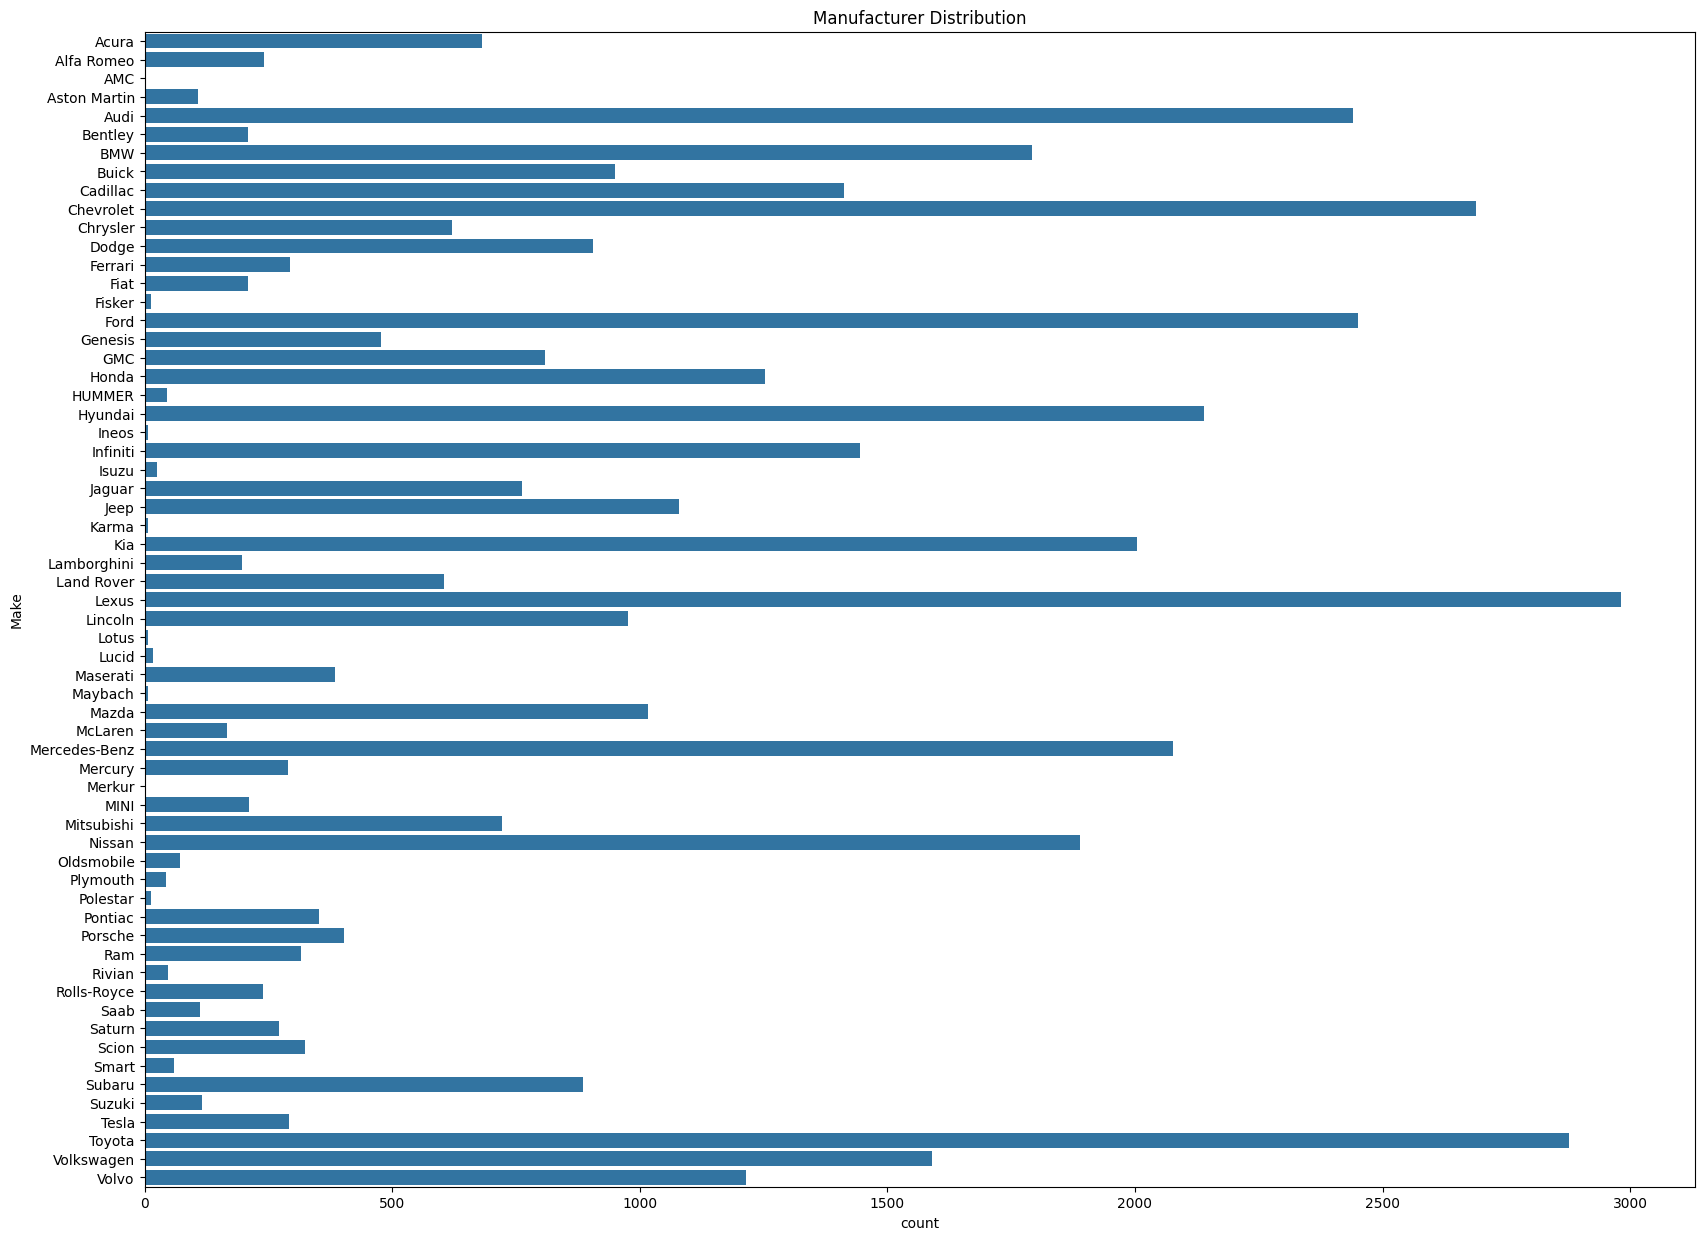

In [77]:
# Find the total number of cars per manufacturer in the dataset
plt.figure(figsize=(20, 15))
sns.countplot(y=data['Make'])
plt.title("Manufacturer Distribution")
plt.show()

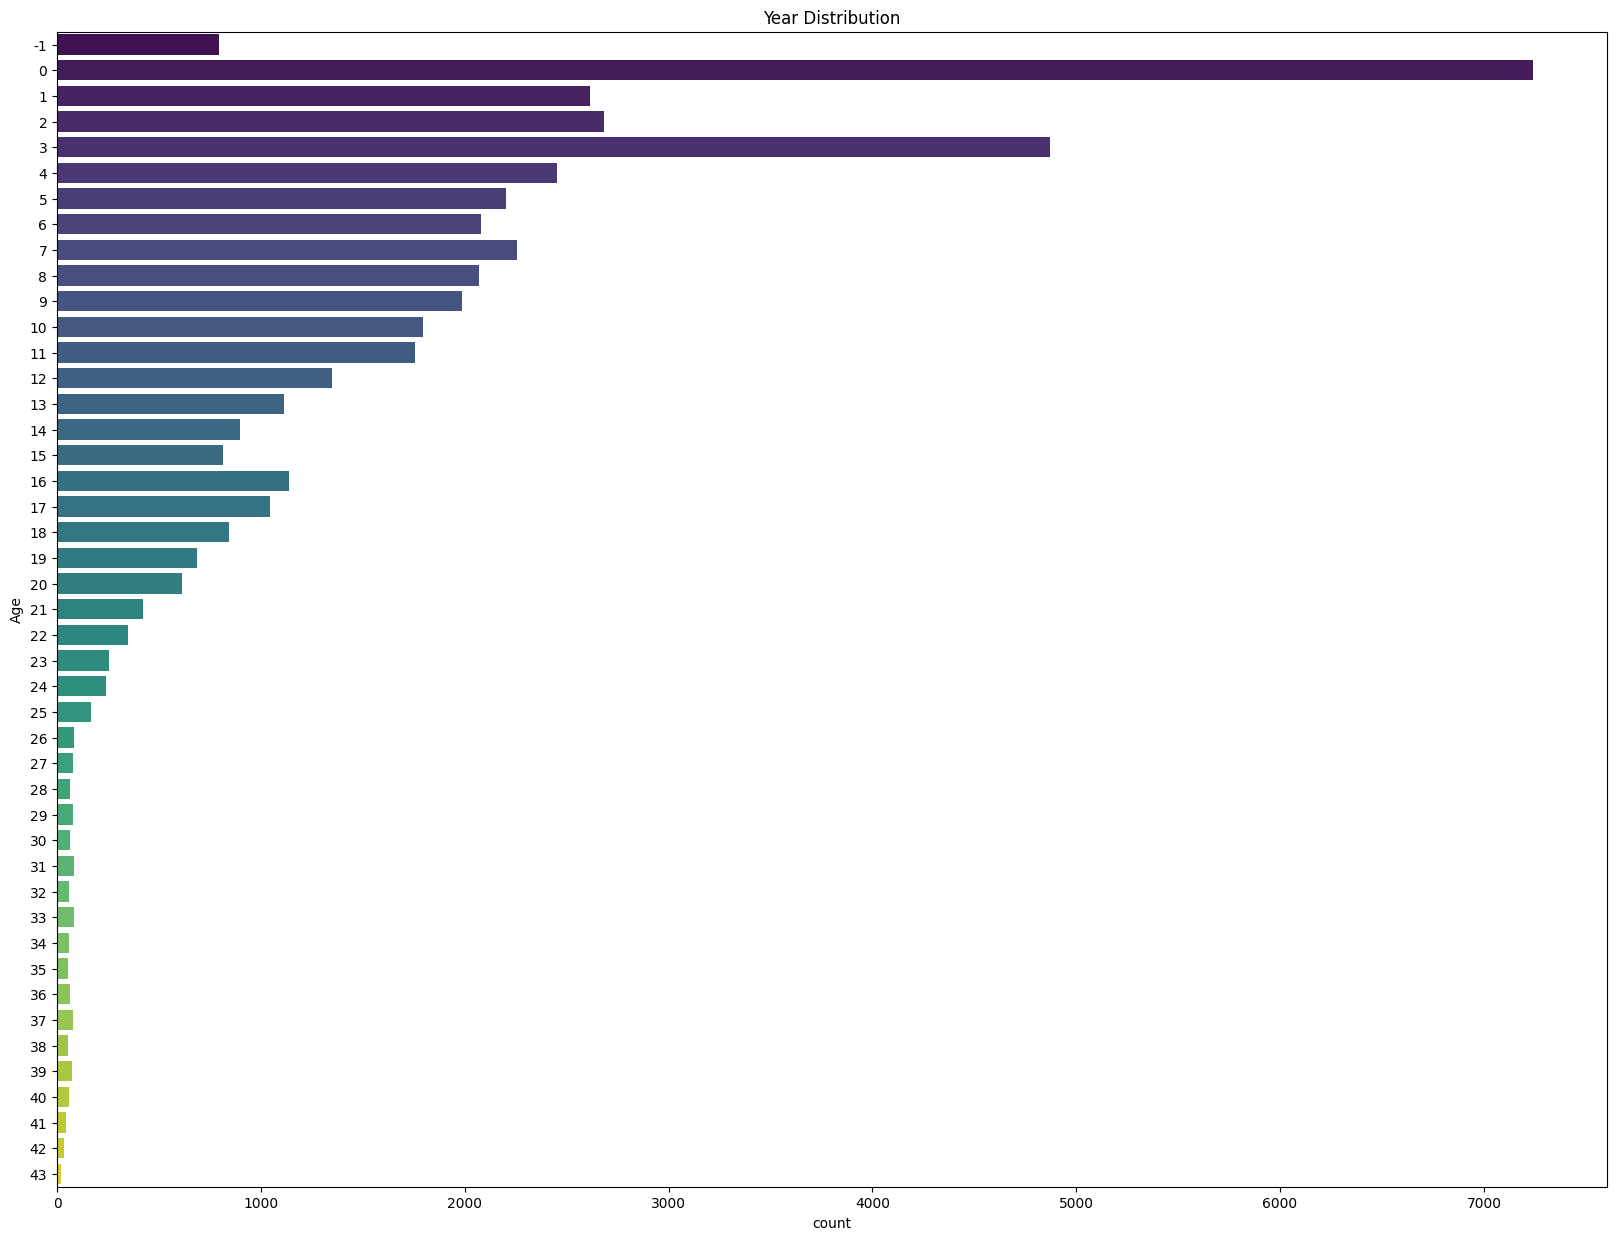

In [79]:
# Find the number of cars made in each year in the dataset
plt.figure(figsize=(20, 15))
sns.countplot(y=data.Age, palette='viridis')
plt.title("Year Distribution")
plt.show()

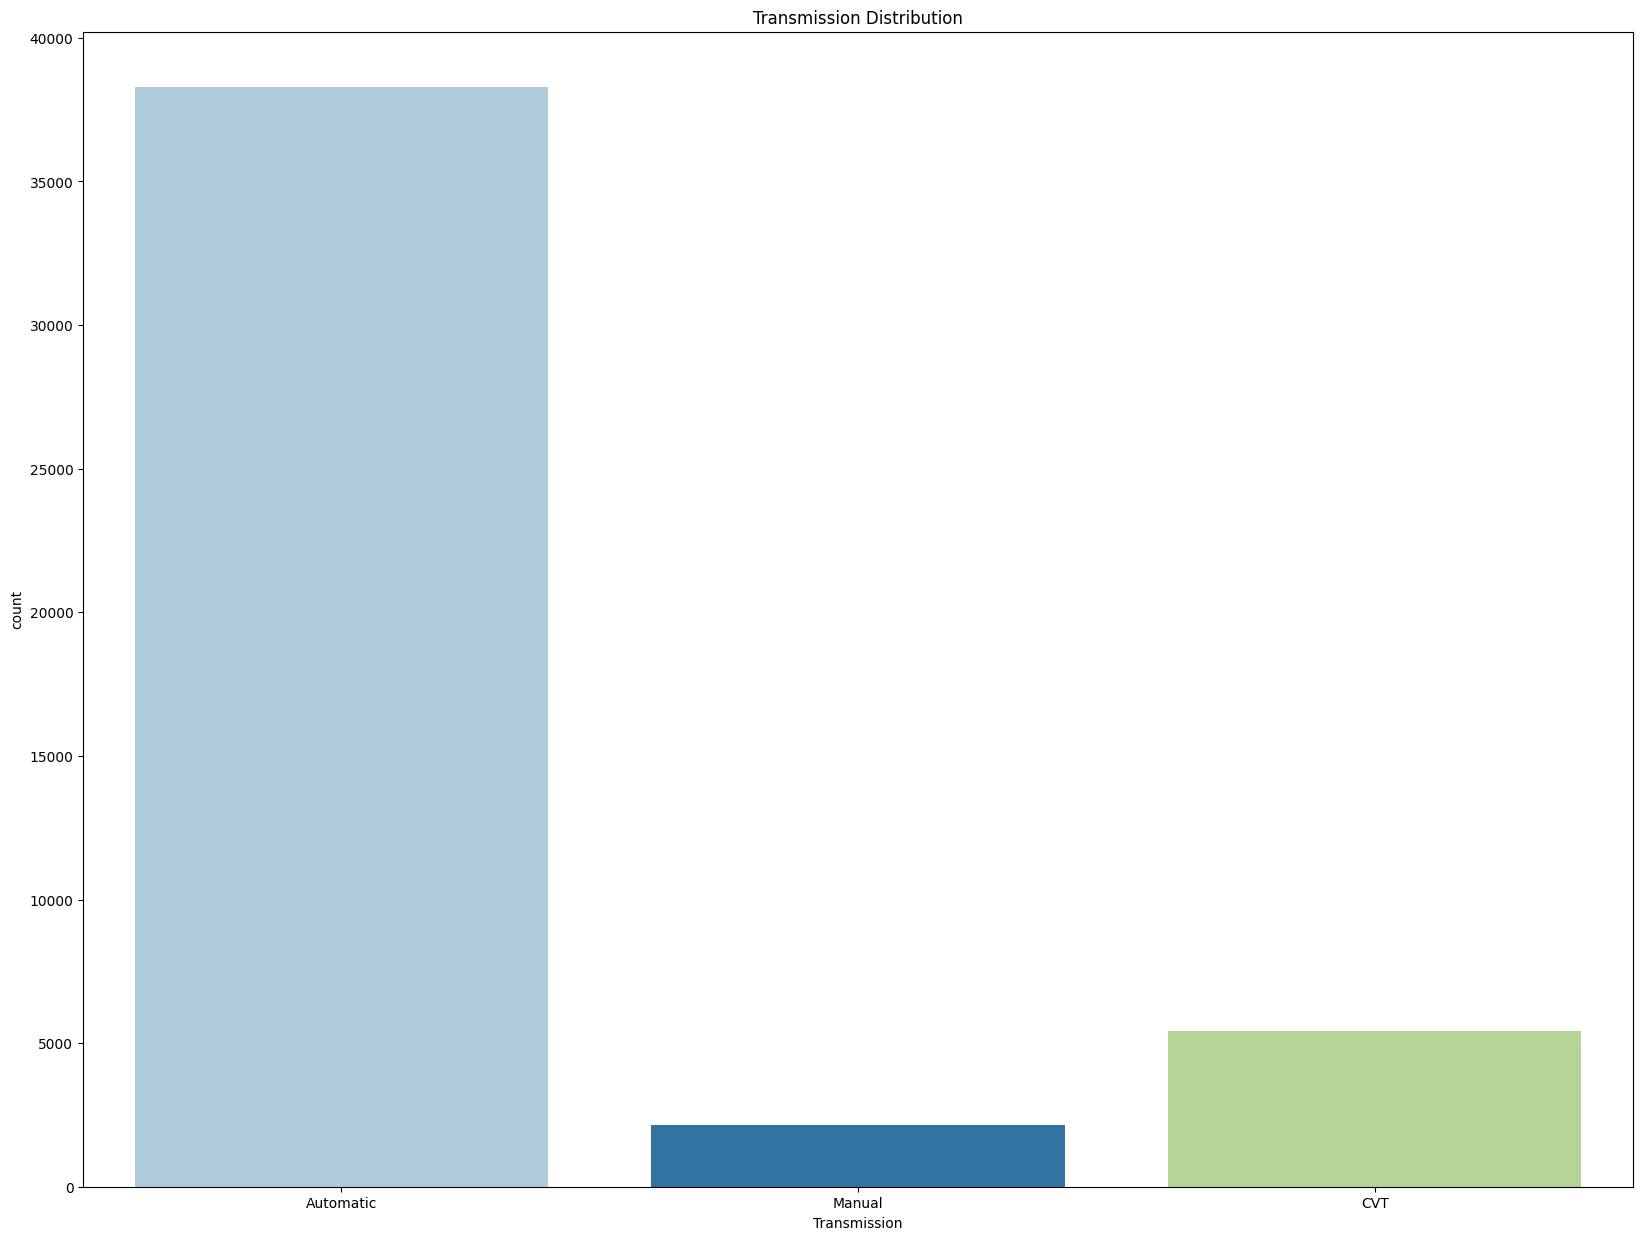

In [80]:
# Number of cars per transmission type
plt.figure(figsize=(20, 15))
sns.countplot(x=data.Transmission, palette='Paired')
plt.title("Transmission Distribution")
plt.show()

In [81]:
# unique elements in data
data.nunique()

Make               62
Model            1066
Age                45
Trim             2332
Mileage         34660
Transmission        3
Color            3217
Engine_Size         8
Fuel_Type           6
Gas_Mileage       117
Drive_Type          3
Latitude         4103
Longitude        4146
Price           14683
dtype: int64

<Axes: xlabel='count', ylabel='Fuel_Type'>

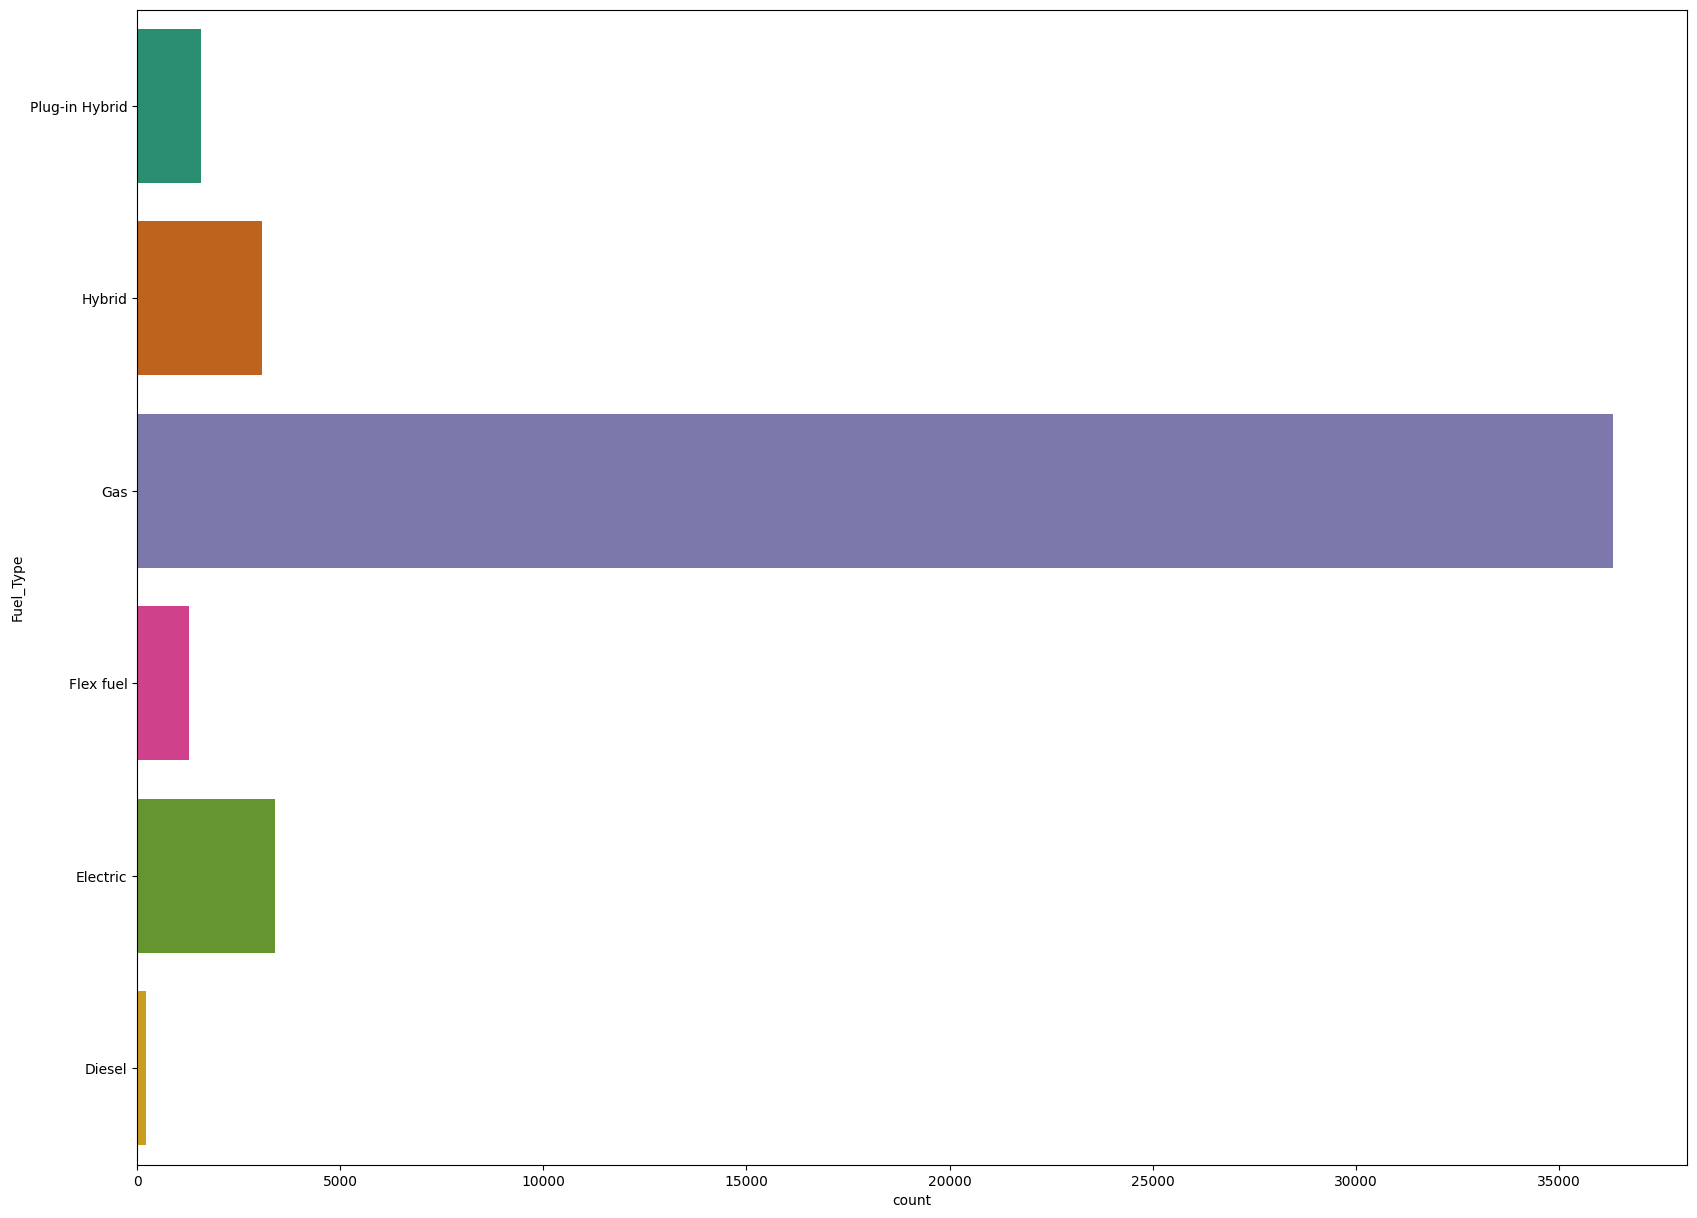

In [82]:
# fuel type distribution
plt.figure(figsize=(20, 15))
sns.countplot(y=data.Fuel_Type.sort_values(ascending=False), palette='Dark2')


In [83]:
# Group rows by make
data.groupby('Make')[['Engine_Size','Gas_Mileage', 'Price']].agg(['min','max','mean','median'])

Engine_Size                        Gas_Mileage         \
                     min   max      mean median         min    max   
Make                                                                 
AMC                  6.0   6.0  6.000000    6.0        17.0   17.0   
Acura                0.0   6.0  4.539589    4.0        15.0   87.0   
Alfa Romeo           4.0   6.0  4.049793    4.0        19.0   77.0   
Aston Martin         8.0  12.0  9.794393    8.0        12.0   21.0   
Audi                 0.0  12.0  4.859836    5.0        14.0  100.0   
...                  ...   ...       ...    ...         ...    ...   
Suzuki               4.0   6.0  4.413793    4.0        16.0   26.0   
Tesla                0.0   0.0  0.000000    0.0        79.0  127.0   
Toyota               0.0   8.0  4.460014    4.0        10.0  127.0   
Volkswagen           0.0  12.0  4.184906    4.0        13.0  119.0   
Volvo                0.0   8.0  4.018930    4.0        16.0  107.0   

                                   Price                                     
                    mean median      min       max           mean    median  
Make                                                                         
AMC            17.000000   17.0  14500.0   14500.0   14500.000000   14500.0  
Acura          29.458944   24.0   2000.0  325000.0   29046.615836   19844.5  
Alfa Romeo     41.842324   26.0   3500.0   63900.0   38579.954357   39995.0  
Aston Martin   16.345794   16.0  32995.0  518286.0  146026.579439  116995.0  
Audi           31.688934   23.0   2650.0  299995.0   53399.008197   44407.5  
...                  ...    ...      ...       ...            ...       ...  
Suzuki         23.008621   25.0   1400.0   17500.0    6540.043103    6439.5  
Tesla         111.883162  116.0  13995.0  145999.0   34481.072165   28995.0  
Toyota         36.549374   30.0   1995.0  169800.0   27773.187761   24998.5  
Volkswagen     30.078616   25.0   1900.0  136000.0   20923.867296   17538.0  
Volvo          39.197531   25.0   1200.0   86915.0   33853.706173   31999.0  

[62 rows x 12 columns]

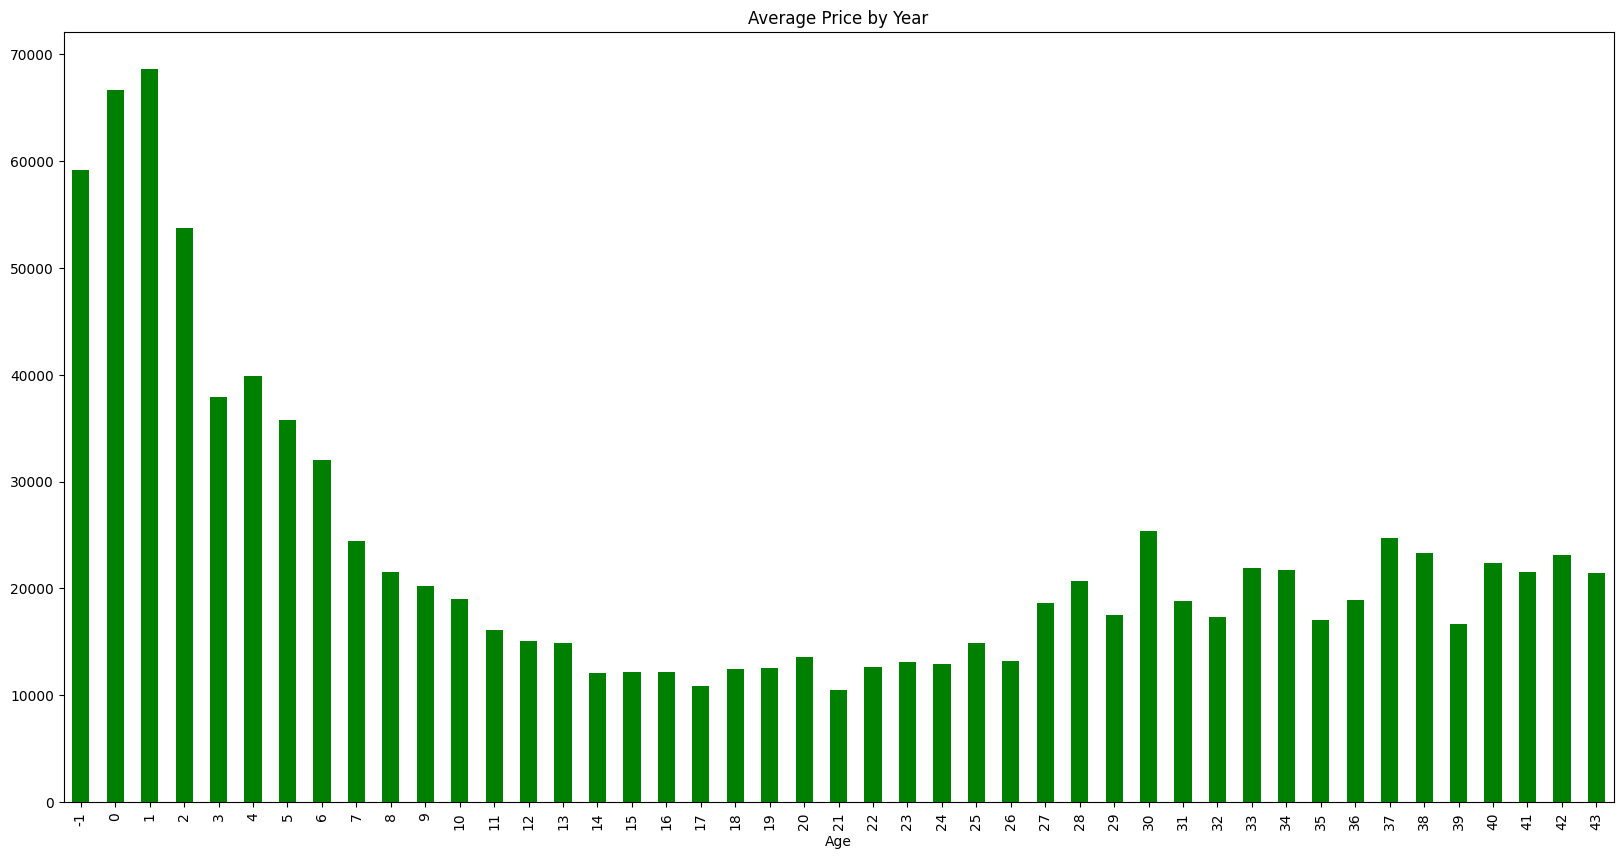

In [85]:
# average price by year
plt.figure(figsize=(20, 10))
data.groupby('Age')['Price'].mean().plot(kind='bar',color='g')
plt.title('Average Price by Year')
plt.show()

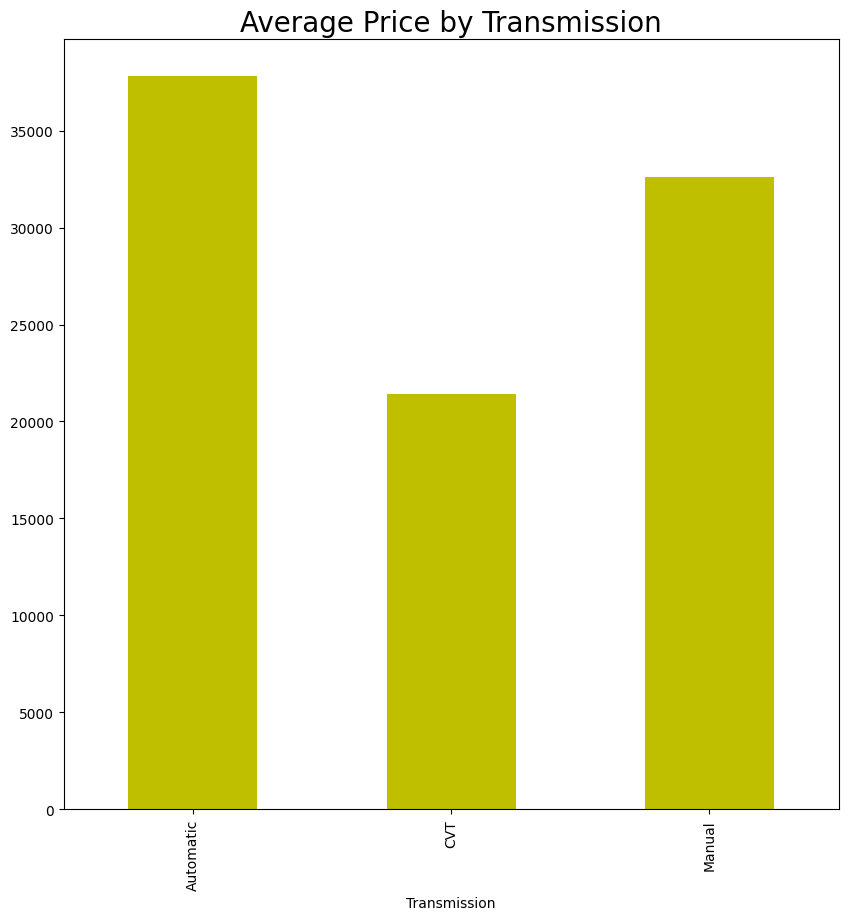

In [86]:
plt.figure(figsize = (10, 10))
data.groupby('Transmission')['Price'].mean().plot(kind = 'bar', color = 'y')
plt.title("Average Price by Transmission", fontsize = 20)
plt.show()

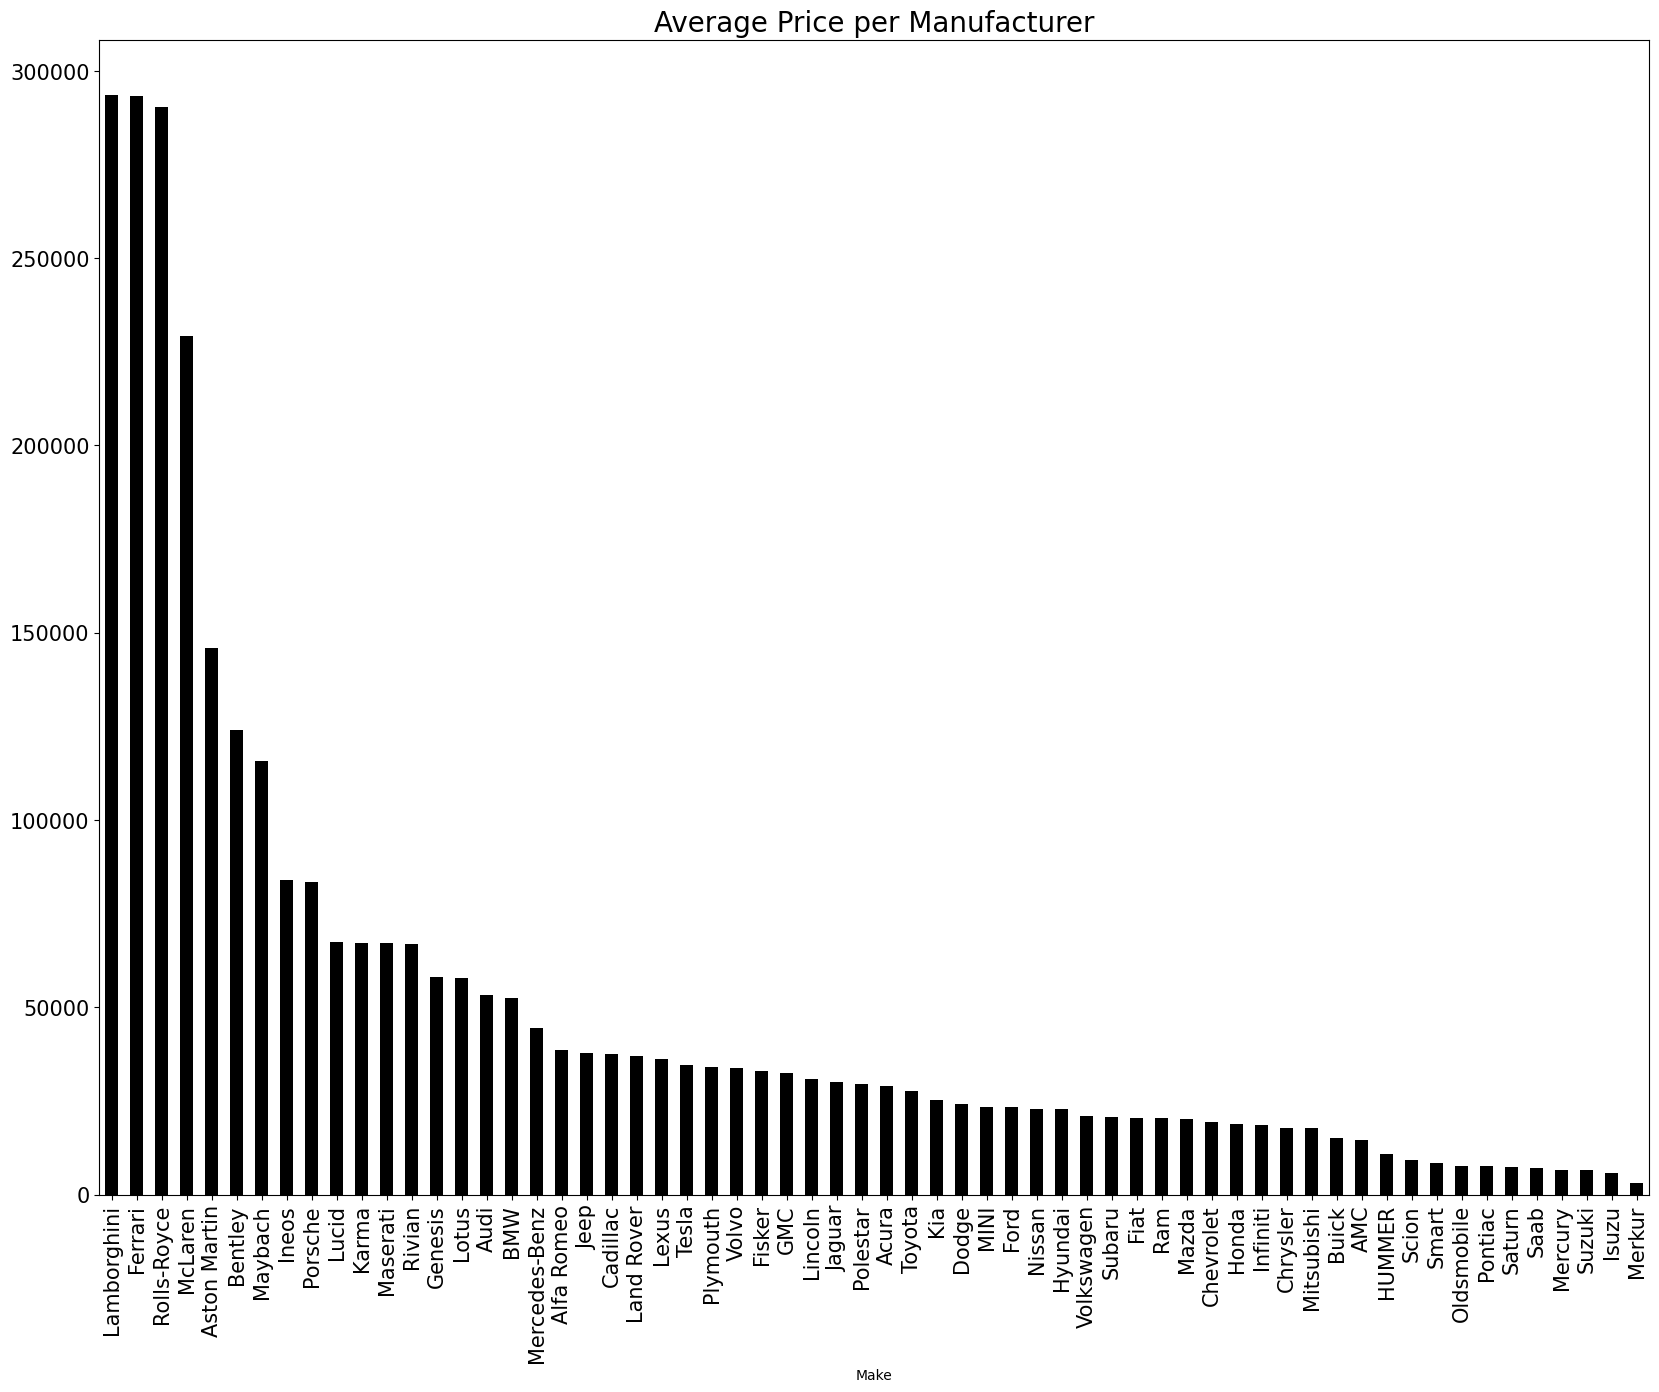

In [87]:
plt.figure(figsize = (20, 15))
data.groupby(['Make'])['Price'].mean().sort_values(ascending = False).plot(kind = 'bar', fontsize = 15, color = 'black')
plt.title("Average Price per Manufacturer", fontsize = 20)
plt.show()

<Axes: xlabel='Drive_Type'>

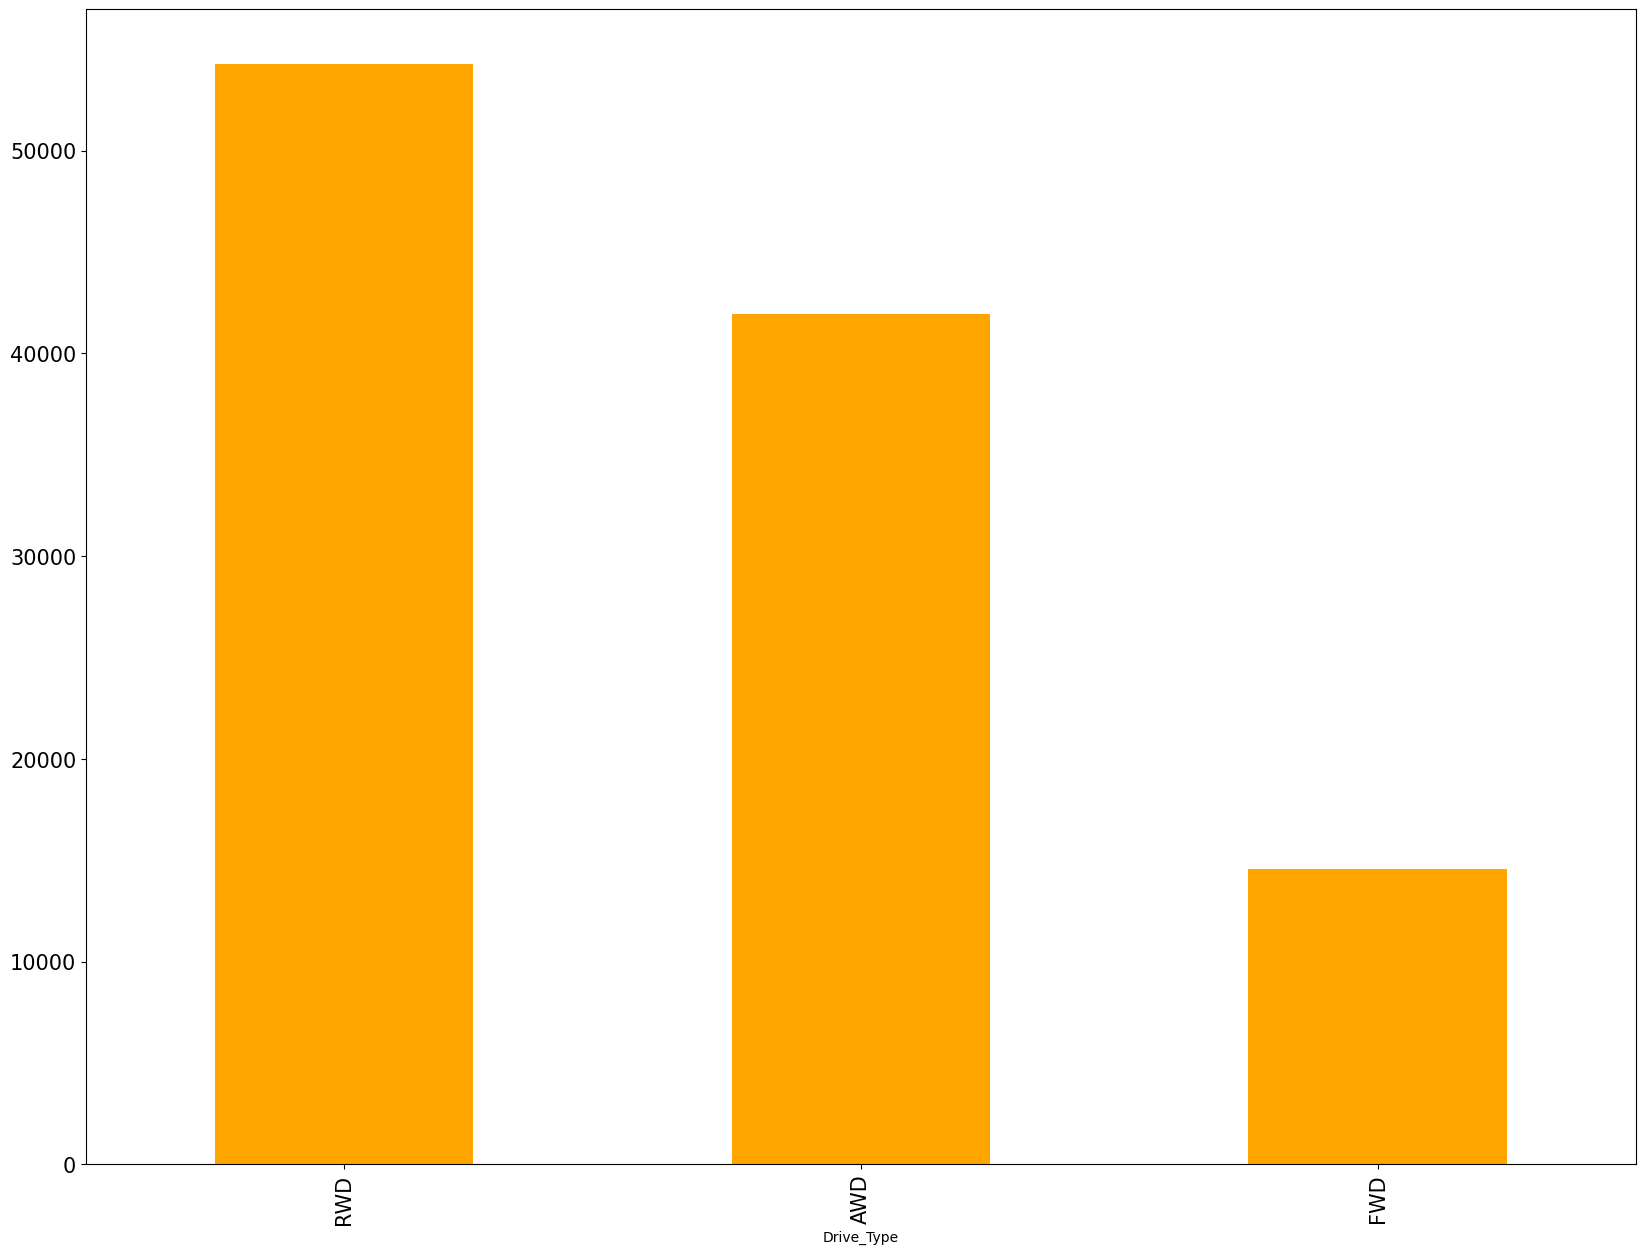

In [88]:
# Group by Drive Type
plt.figure(figsize = (20, 15))
data.groupby(['Drive_Type'])['Price'].mean().sort_values(ascending = False).plot(kind = 'bar', fontsize = 15, color = 'orange')

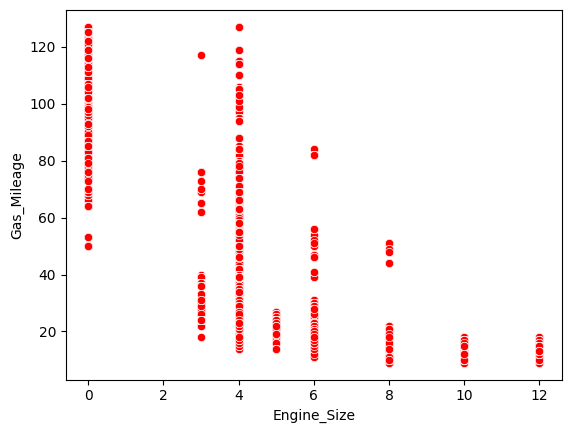

In [89]:
sns.scatterplot(x='Engine_Size',y='Gas_Mileage', data=data, color='r')
plt.show()

<Axes: xlabel='Gas_Mileage'>

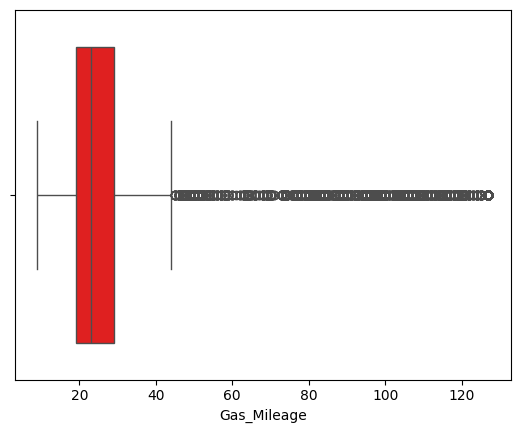

In [90]:
# Boxplot of MPG
sns.boxplot(x='Gas_Mileage', data=data,color='r')

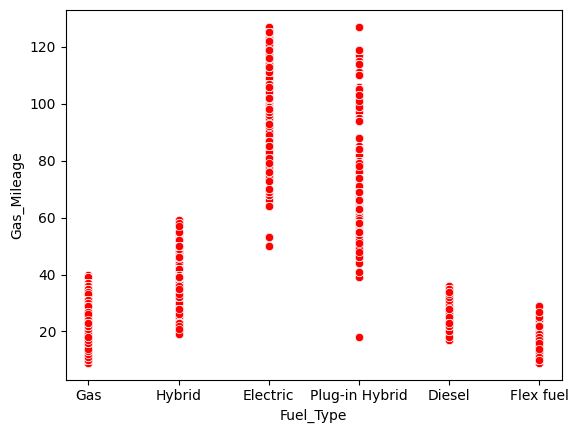

In [91]:
sns.scatterplot(x='Fuel_Type',y='Gas_Mileage', data=data, color='r')
plt.show()

<Axes: >

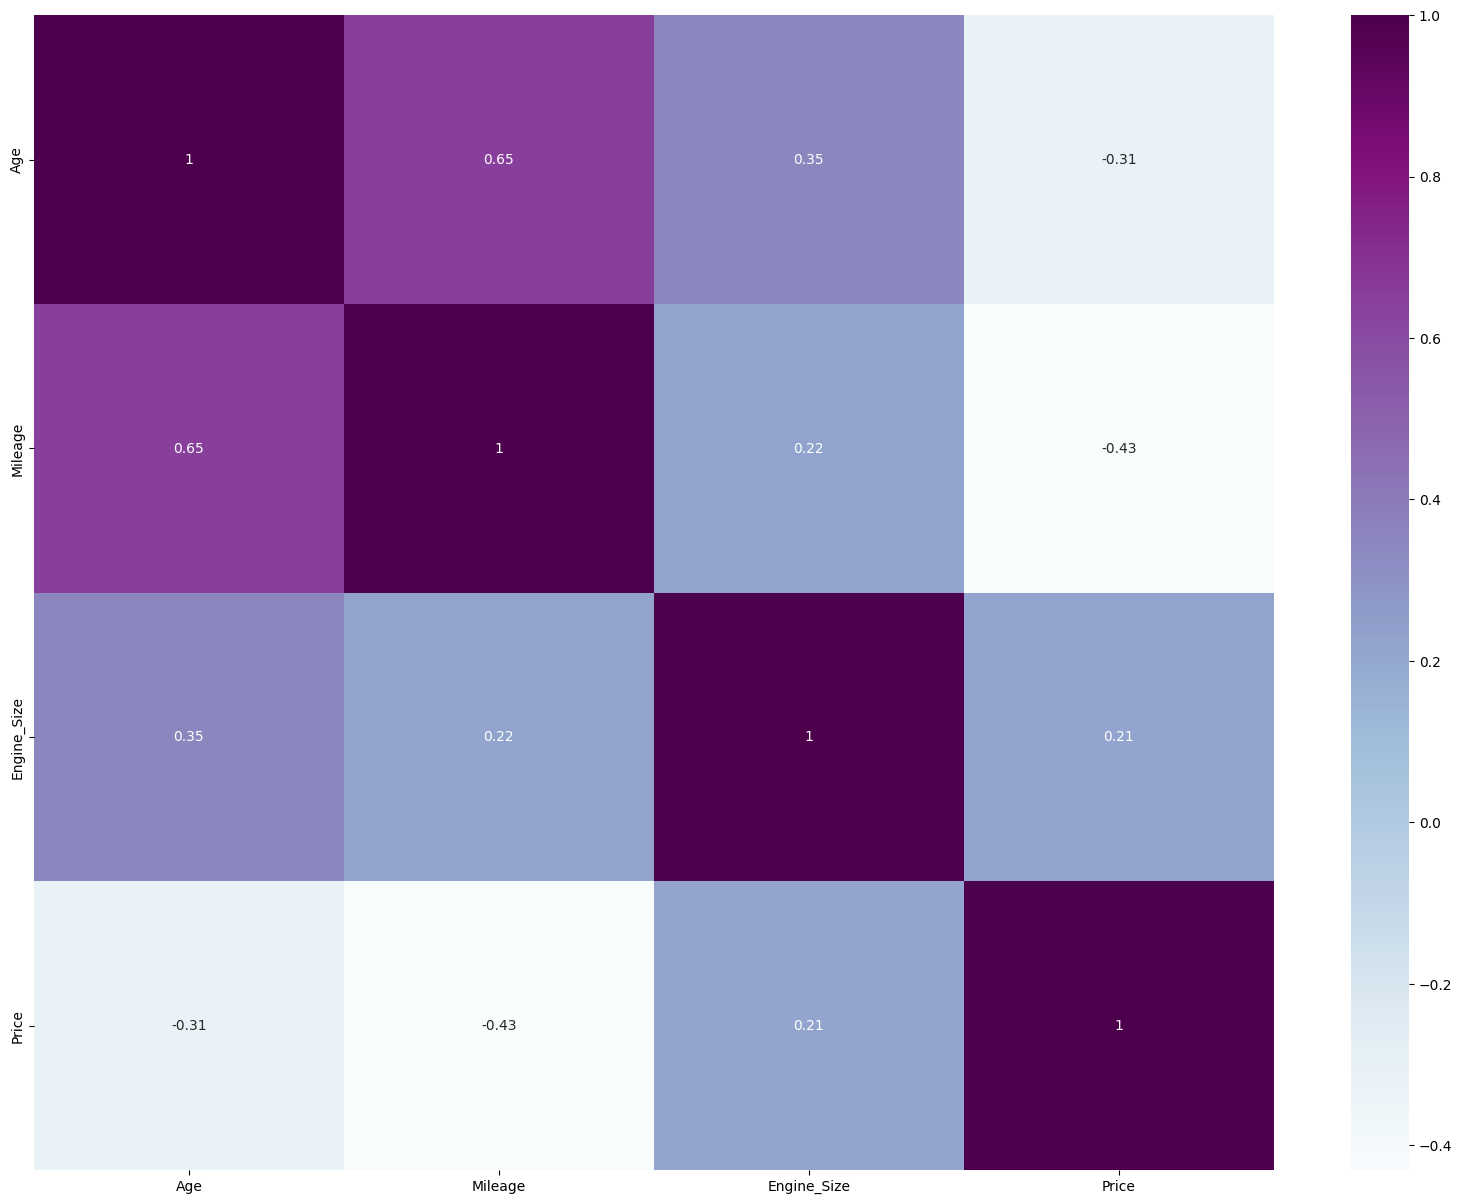

In [93]:
plt.figure(figsize = (20, 15))
numeric_columns = ['Age', 'Mileage', 'Engine_Size', 'Price']
heatmap_data = data[numeric_columns].corr()
sns.heatmap(heatmap_data, annot=True, cmap='BuPu')

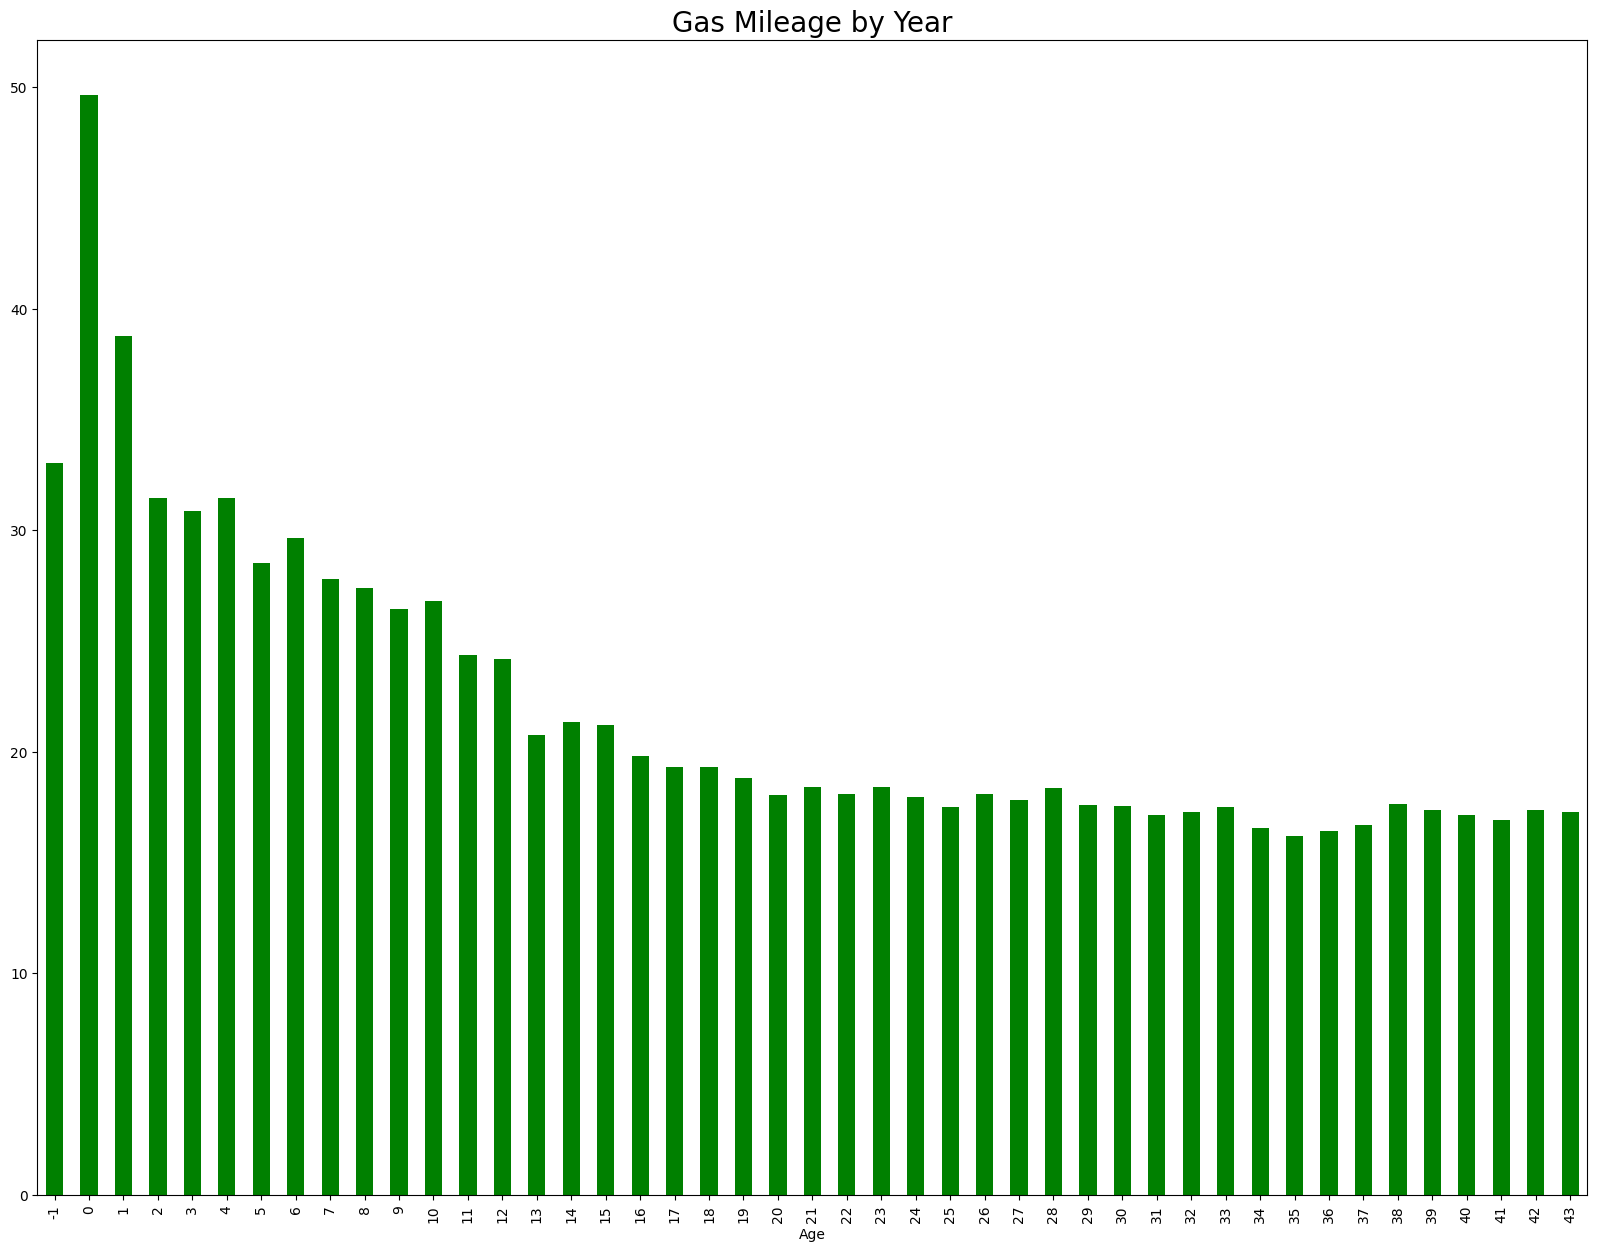

In [95]:
# Gas Mileage by Year
plt.figure(figsize = (20, 15))
data.groupby('Age')['Gas_Mileage'].mean().plot(kind = 'bar', color = 'g')
plt.title("Gas Mileage by Year", fontsize = 20)
plt.show()

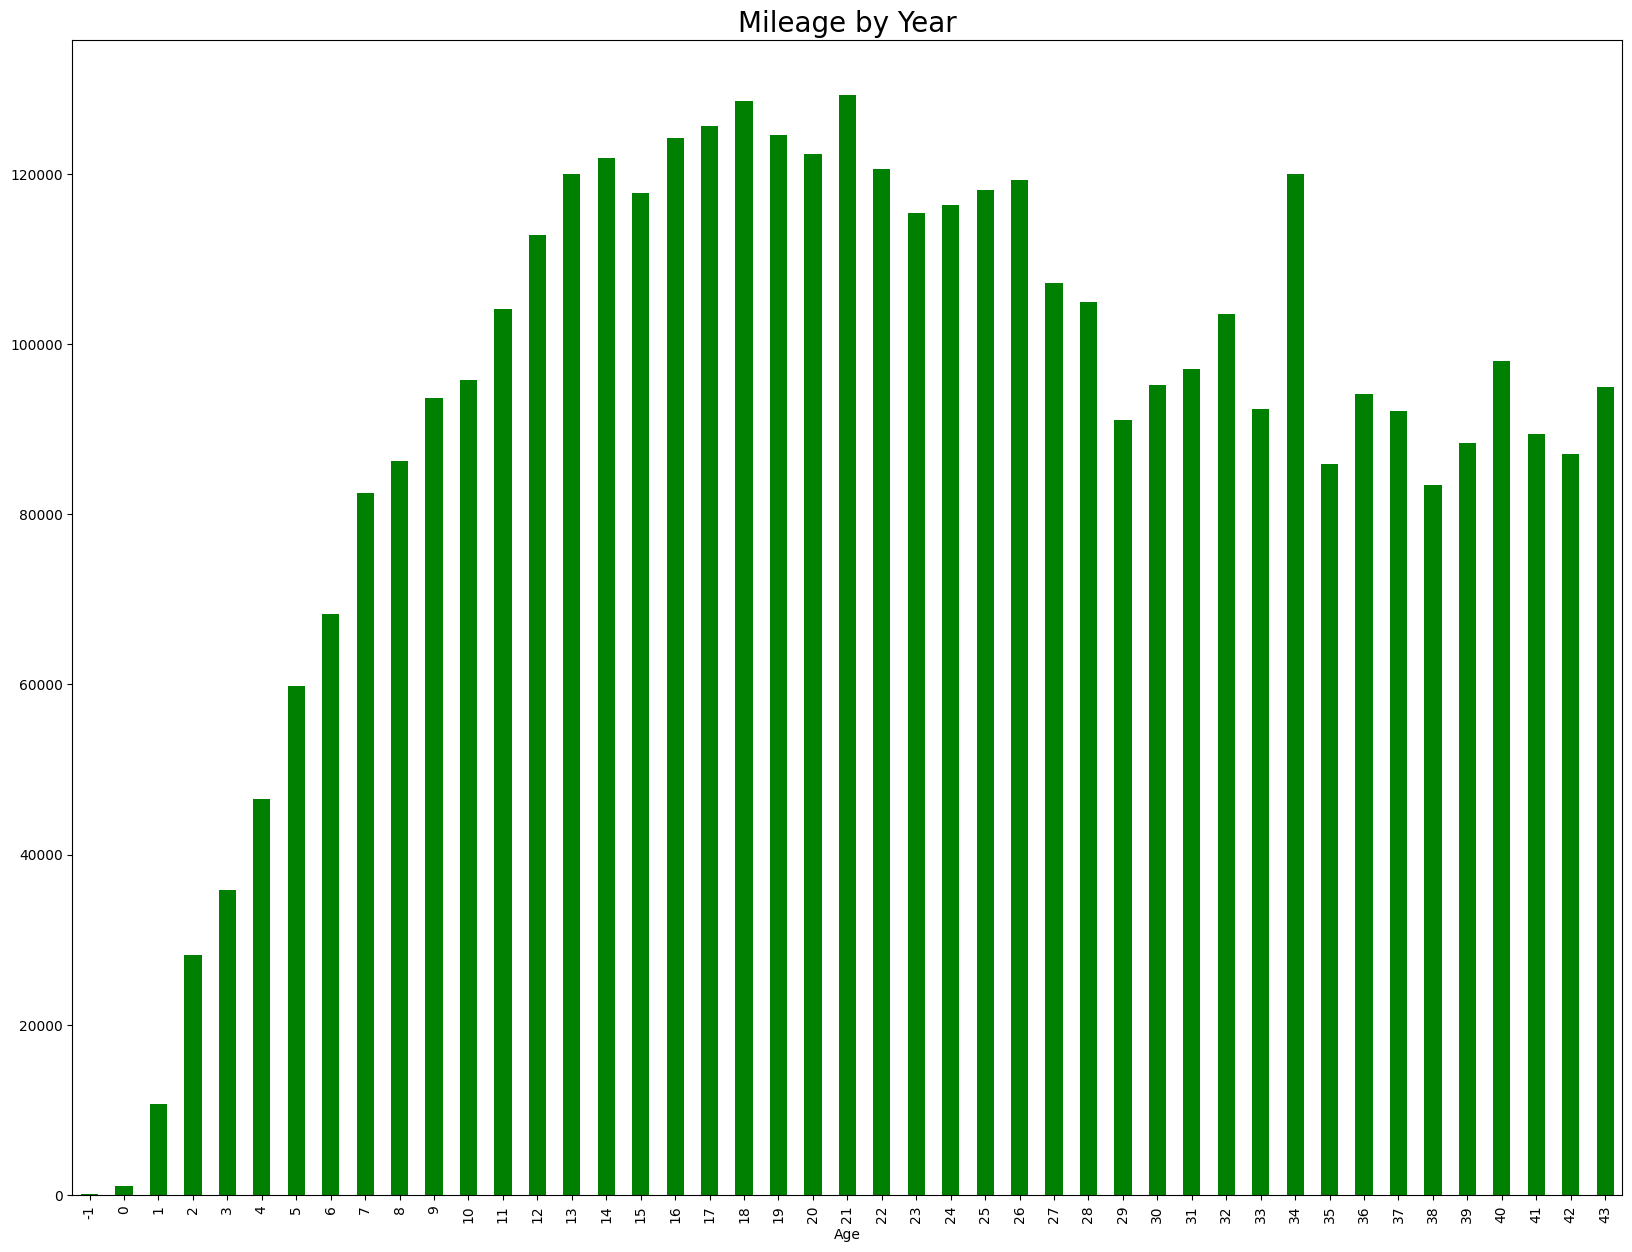

In [97]:
# Mileage by Year
plt.figure(figsize = (20, 15))
data.groupby('Age')['Mileage'].mean().plot(kind = 'bar', color = 'g')
plt.title("Mileage by Year", fontsize = 20)
plt.show()

In [ ]:
data.info()

# 3) Data Manipulation

In [163]:
print(len(data.index))

45057


In [164]:
frame = data.copy()

In [165]:
frame.sample()

,Make,Model,Age,Trim,Mileage,Transmission,Color,Engine_Size,Fuel_Type,Gas_Mileage,Drive_Type,Latitude,Longitude,Price
28071,Hyundai,Tucson Hybrid,0,Limited,0.0,Automatic,Amazon Gray,4.0,Hybrid,37.0,AWD,0.711127,-1.2904,41745.0


## Split the Data

In [166]:
shuffled_data = shuffle(frame, random_state=1)
X = shuffled_data.drop('Price', axis=1)
y = shuffled_data['Price']

In [167]:
# Training and Test Set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [168]:
print("The size of the input train data is: {}".format(X_train.shape))
print("The size of the output train data is: {}".format(y_train.shape))
print("The size of the input test data is: {}".format(X_test.shape))
print("The size of the output test data is: {}".format(y_test.shape))

The size of the input train data is: (36045, 13)
The size of the output train data is: (36045,)
The size of the input test data is: (9012, 13)
The size of the output test data is: (9012,)


In [169]:
X_train.sample()

,Make,Model,Age,Trim,Mileage,Transmission,Color,Engine_Size,Fuel_Type,Gas_Mileage,Drive_Type,Latitude,Longitude
14762,Chrysler,Pacifica Hybrid,1,Pinnacle,10.0,Automatic,Bright White Clearcoat,6.0,Plug-in Hybrid,82.0,FWD,0.704387,-1.292732


## Encode Make

In [170]:
make_encoder = TargetEncoder(cols='Make')

In [171]:
make_encoder.fit(X_train['Make'], y_train.to_frame()['Price'])

TargetEncoder(cols=['Make'])

In [172]:
X_train['Make'] = make_encoder.transform(X_train['Make'])

In [173]:
X_test['Make'] = make_encoder.transform(X_test['Make'])

In [174]:
X_train.sample()

,Make,Model,Age,Trim,Mileage,Transmission,Color,Engine_Size,Fuel_Type,Gas_Mileage,Drive_Type,Latitude,Longitude
35565,37235.814969,Discovery Sport,1,P250 SE,8294.0,Automatic,Fuji White,4.0,Gas,20.0,AWD,0.700867,-1.311212


## Encode Model

In [175]:
model_encoder = TargetEncoder(cols='Model')
model_encoder.fit(X_train['Model'], y_train.to_frame()['Price'])
X_train['Model'] = model_encoder.transform(X_train['Model'])
X_test['Model'] = model_encoder.transform(X_test['Model'])

In [176]:
X_train.sample()

,Make,Model,Age,Trim,Mileage,Transmission,Color,Engine_Size,Fuel_Type,Gas_Mileage,Drive_Type,Latitude,Longitude
50433,22624.752972,55638.636331,0,Performance,5.0,Manual,Everest White Pearl Tricoat/Super Black,6.0,Gas,20.0,RWD,0.703879,-1.328023


## Encode Trim

In [177]:
trim_encoder = TargetEncoder(cols='Trim')
trim_encoder.fit(X_train['Trim'], y_train.to_frame()['Price'])
X_train['Trim'] = trim_encoder.transform(X_train['Trim'])
X_test['Trim'] = trim_encoder.transform(X_test['Trim'])

In [178]:
X_train.sample()

,Make,Model,Age,Trim,Mileage,Transmission,Color,Engine_Size,Fuel_Type,Gas_Mileage,Drive_Type,Latitude,Longitude
6128,48802.287416,37299.115338,2,39345.639507,42275.0,Automatic,Alpine White,6.0,Gas,23.0,AWD,0.710293,-1.295525


## Encode Color

In [179]:
color_encoder = TargetEncoder(cols='Color')
color_encoder.fit(X_train['Color'], y_train.to_frame()['Price'])
X_train['Color'] = color_encoder.transform(X_train['Color'])
X_test['Color'] = color_encoder.transform(X_test['Color'])

In [180]:
X_train.sample()

,Make,Model,Age,Trim,Mileage,Transmission,Color,Engine_Size,Fuel_Type,Gas_Mileage,Drive_Type,Latitude,Longitude
5603,48802.287416,58454.303177,2,50436.320823,7482.0,Automatic,44130.446556,8.0,Gas,17.0,AWD,0.709169,-1.293587


## One Hot Encoding

In [181]:
X_train.sample()

,Make,Model,Age,Trim,Mileage,Transmission,Color,Engine_Size,Fuel_Type,Gas_Mileage,Drive_Type,Latitude,Longitude
20344,23252.79817,20299.454151,19,26740.931677,111779.0,Automatic,30865.922774,6.0,Gas,18.0,FWD,0.680727,-1.529182


In [182]:
encoder = OneHotEncoder()
encoder.fit(X_train[['Transmission', 'Fuel_Type', 'Drive_Type']])
one_hot_encoded_output_train = encoder.transform(X_train[['Transmission', 'Fuel_Type', 'Drive_Type']])
one_hot_encoded_output_test = encoder.transform(X_test[['Transmission', 'Fuel_Type', 'Drive_Type']])

In [183]:
X_train = pd.concat([X_train, one_hot_encoded_output_train], axis=1)
X_test = pd.concat([X_test, one_hot_encoded_output_test], axis=1)

In [184]:
X_train = X_train.drop(['Transmission', 'Fuel_Type', 'Drive_Type'],axis=1)
X_test = X_test.drop(['Transmission', 'Fuel_Type', 'Drive_Type'],axis=1)

In [185]:
X_train.sample()

,Make,Model,Age,Trim,Mileage,Color,Engine_Size,Gas_Mileage,Latitude,Longitude,...,Transmission_3,Fuel_Type_1,Fuel_Type_2,Fuel_Type_3,Fuel_Type_4,Fuel_Type_5,Fuel_Type_6,Drive_Type_1,Drive_Type_2,Drive_Type_3
50236,22624.752972,9575.871957,8,18578.866477,91352.0,30865.922774,4.0,35.0,0.709222,-1.296005,...,1,1,0,0,0,0,0,0,0,1


In [186]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36045 entries, 11049 to 32382
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Make            36045 non-null  float64
 1   Model           36045 non-null  float64
 2   Age             36045 non-null  int64  
 3   Trim            36045 non-null  float64
 4   Mileage         36045 non-null  float64
 5   Color           36045 non-null  float64
 6   Engine_Size     36045 non-null  float64
 7   Gas_Mileage     36045 non-null  float64
 8   Latitude        36045 non-null  float64
 9   Longitude       36045 non-null  float64
 10  Transmission_1  36045 non-null  int64  
 11  Transmission_2  36045 non-null  int64  
 12  Transmission_3  36045 non-null  int64  
 13  Fuel_Type_1     36045 non-null  int64  
 14  Fuel_Type_2     36045 non-null  int64  
 15  Fuel_Type_3     36045 non-null  int64  
 16  Fuel_Type_4     36045 non-null  int64  
 17  Fuel_Type_5     36045 non-null  

## Standardization/Normalization

In [187]:
X_train.sample()

,Make,Model,Age,Trim,Mileage,Color,Engine_Size,Gas_Mileage,Latitude,Longitude,...,Transmission_3,Fuel_Type_1,Fuel_Type_2,Fuel_Type_3,Fuel_Type_4,Fuel_Type_5,Fuel_Type_6,Drive_Type_1,Drive_Type_2,Drive_Type_3
13453,19035.746009,39841.441656,10,50436.320823,7813.0,32804.552336,8.0,17.0,0.704849,-1.834194,...,0,1,0,0,0,0,0,1,0,0


In [188]:
cols_to_scale = ['Age', 'Mileage', 'Engine_Size', 'Gas_Mileage', 'Latitude', 'Longitude']

In [189]:
# scaler = StandardScaler()
# X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
# X_test[cols_to_scale] = scaler.fit_transform(X_test[cols_to_scale])

In [190]:
X_train.shape

(36045, 22)

# 4) Machine Learning Analysis

In [191]:
mse = []
mae = []

## K-Neighbors Regressor

In [192]:
knn = KNeighborsRegressor(n_neighbors=2)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
y_pred = pd.DataFrame(y_pred, columns=['Predicted Price'])
results = pd.concat([y_pred, y_test.to_frame().reset_index(drop=True)], axis=1, ignore_index=False)
mse.append(int(mean_squared_error(y_pred, y_test)))
mae.append(int(mean_absolute_error(y_pred, y_test)))

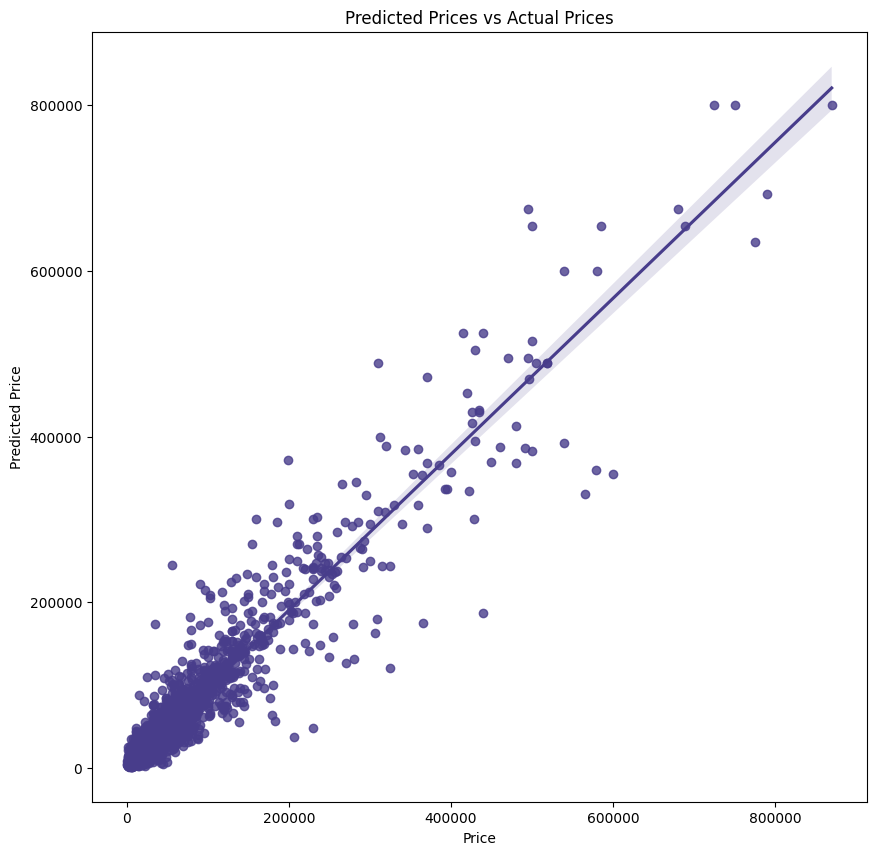

In [193]:
plt.figure(figsize=(10,10))
sns.regplot(data=results, y='Predicted Price', x='Price', color='darkslateblue', marker='o')
plt.title('Predicted Prices vs Actual Prices')
plt.show()

## PLS Regression

In [194]:
pls = PLSRegression(n_components=10)
pls.fit(X_train, y_train)
y_pred = pls.predict(X_test)
y_pred = pd.DataFrame(y_pred, columns=['Predicted Price'])
results = pd.concat([y_pred, y_test.to_frame().reset_index(drop=True)], axis=1, ignore_index=False)
mse.append(int(mean_squared_error(y_pred, y_test)))
mae.append(int(mean_absolute_error(y_pred, y_test)))

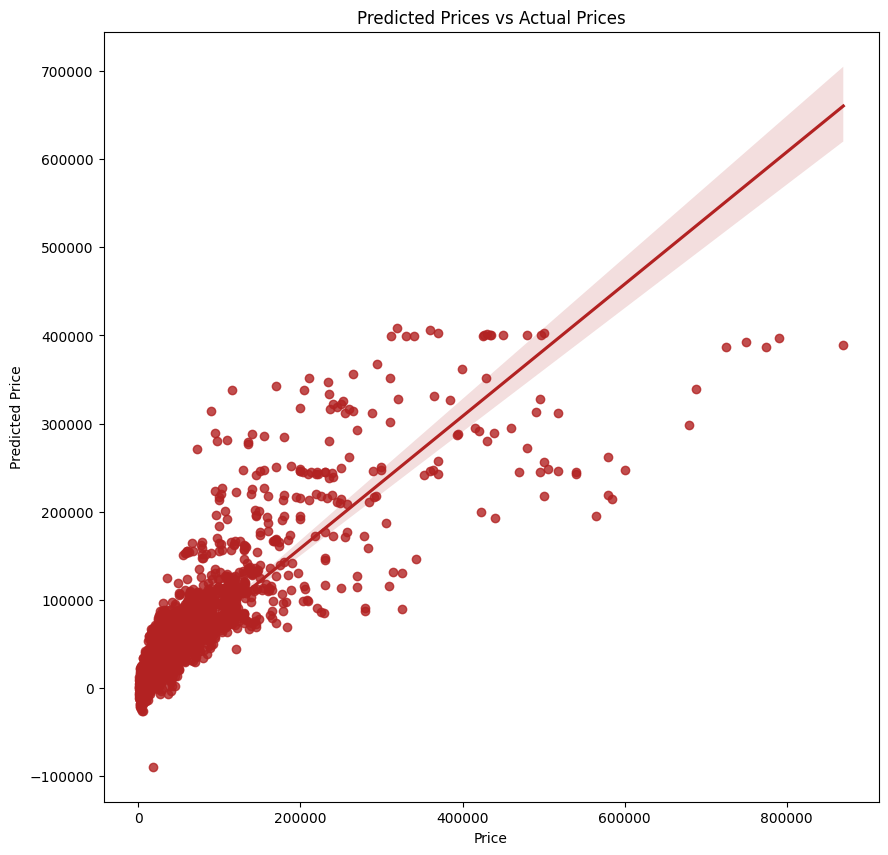

In [195]:
plt.figure(figsize=(10,10))
sns.regplot(data=results, y='Predicted Price', x='Price', color='firebrick', marker='o')
plt.title('Predicted Prices vs Actual Prices')
plt.show()

## Decision Tree Regressor

In [196]:
dt = DecisionTreeRegressor(splitter='random')
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
y_pred = pd.DataFrame(y_pred, columns=['Predicted Price'])
results = pd.concat([y_pred, y_test.to_frame().reset_index(drop=True)], axis=1, ignore_index=False)
mse.append(int(mean_squared_error(y_pred, y_test)))
mae.append(int(mean_absolute_error(y_pred, y_test)))

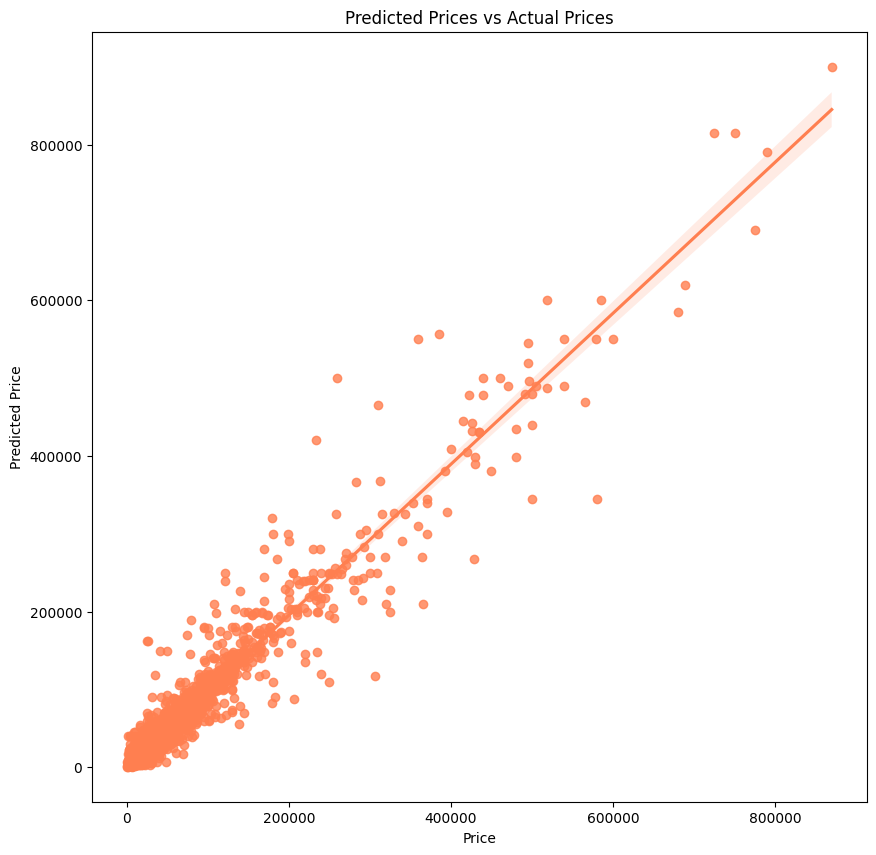

In [197]:
plt.figure(figsize=(10,10))
sns.regplot(data=results, y='Predicted Price', x='Price', color='coral', marker='o')
plt.title('Predicted Prices vs Actual Prices')
plt.show()

## Random Forest Regressor

In [198]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_pred = pd.DataFrame(y_pred, columns=['Predicted Price'])
results = pd.concat([y_pred, y_test.to_frame().reset_index(drop=True)], axis=1, ignore_index=False)
mse.append(int(mean_squared_error(y_pred, y_test)))
mae.append(int(mean_absolute_error(y_pred, y_test)))

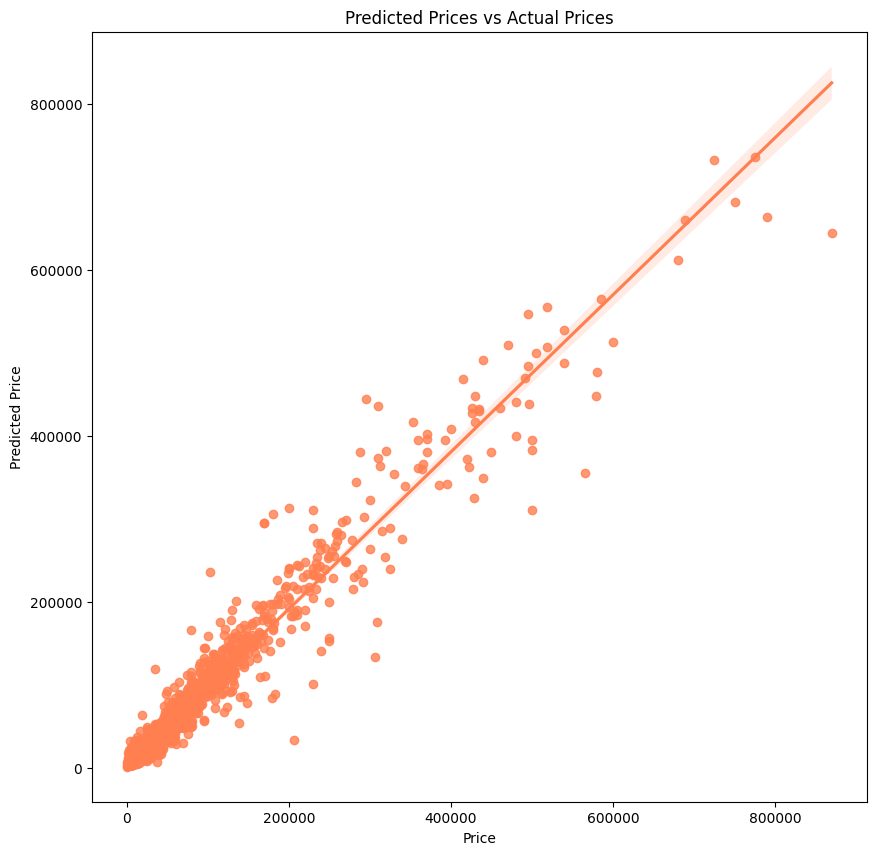

In [199]:
plt.figure(figsize=(10,10))
sns.regplot(data=results, y='Predicted Price', x='Price', color='coral', marker='o')
plt.title('Predicted Prices vs Actual Prices')
plt.show()

## Gradient Boosting Regressor

In [200]:
gb = GradientBoostingRegressor()
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
y_pred = pd.DataFrame(y_pred, columns=['Predicted Price'])
results = pd.concat([y_pred, y_test.to_frame().reset_index(drop=True)], axis=1, ignore_index=False)
mse.append(int(mean_squared_error(y_pred, y_test)))
mae.append(int(mean_absolute_error(y_pred, y_test)))

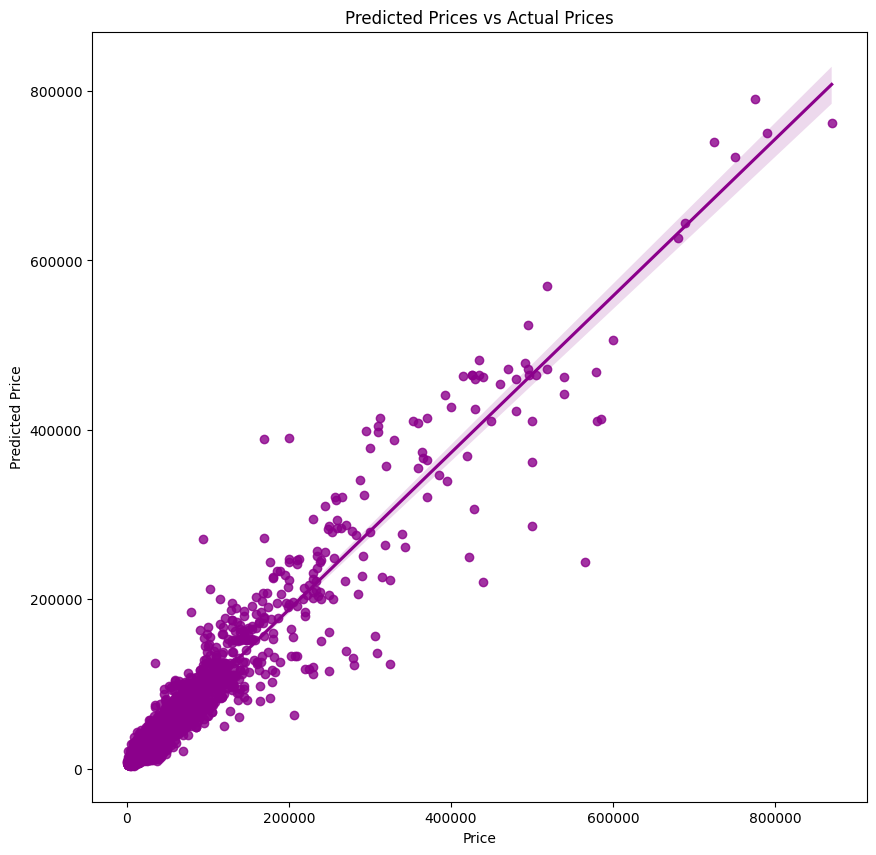

In [201]:
plt.figure(figsize=(10,10))
sns.regplot(data=results, y='Predicted Price', x='Price', color='darkmagenta', marker='o')
plt.title('Predicted Prices vs Actual Prices')
plt.show()

## MLP Regressor

In [202]:
mlp = MLPRegressor(hidden_layer_sizes=50, alpha=0.001, solver='lbfgs', learning_rate='adaptive')
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
y_pred = pd.DataFrame(y_pred, columns=['Predicted Price'])
results = pd.concat([y_pred, y_test.to_frame().reset_index(drop=True)], axis=1, ignore_index=False)
mse.append(int(mean_squared_error(y_pred, y_test)))
mae.append(int(mean_absolute_error(y_pred, y_test)))

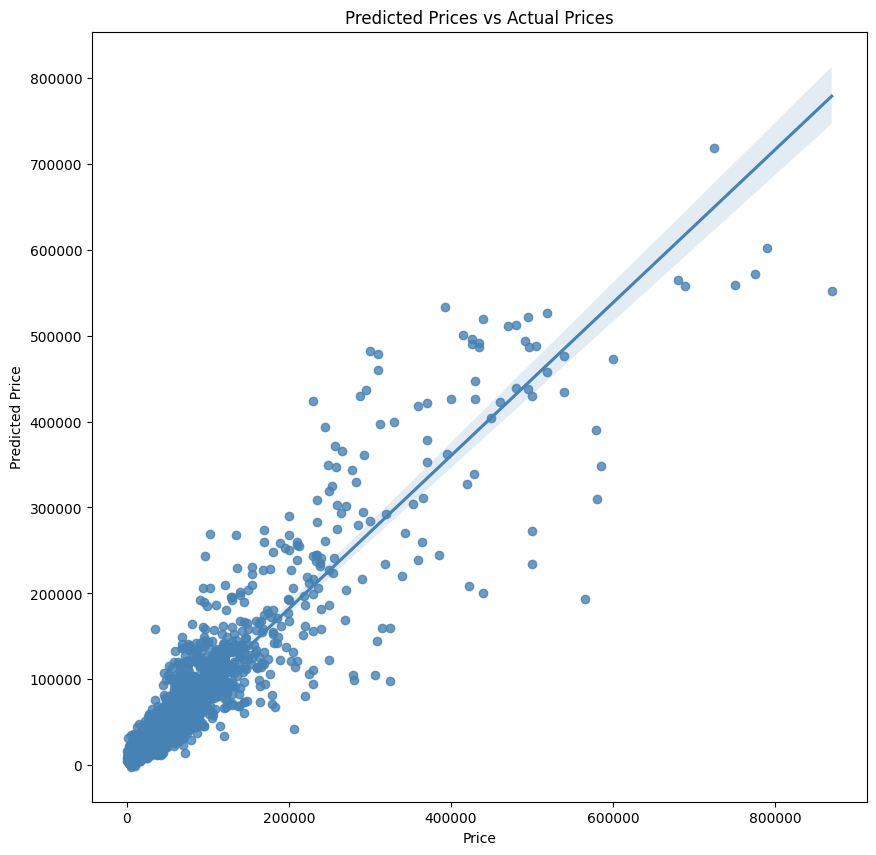

In [203]:
plt.figure(figsize=(10,10))
sns.regplot(data=results, y='Predicted Price', x='Price', color='steelblue', marker='o')
plt.title('Predicted Prices vs Actual Prices')
plt.show()

## Dataframe of Machine Learning Models

In [204]:
models = {'Models': ['K Nearest Regressor', 'PLS Regression', 'Decision Tree Regressor', 'Random Forest Regressor', 'Gradient Boosting Regressor', 'MLP Regressor'], 'Mean Absolute Error': mae, 'Mean Squared Error': mse}
model_dataframe = pd.DataFrame(models)

In [205]:
model_dataframe

,Models,Mean Absolute Error,Mean Squared Error
0,K Nearest Regressor,6147,210201965
1,PLS Regression,10905,614785755
2,Decision Tree Regressor,4704,146916505
3,Random Forest Regressor,3634,102794072
4,Gradient Boosting Regressor,5915,182107898
5,MLP Regressor,7950,323855895


## Barplot of Machine Learning Models

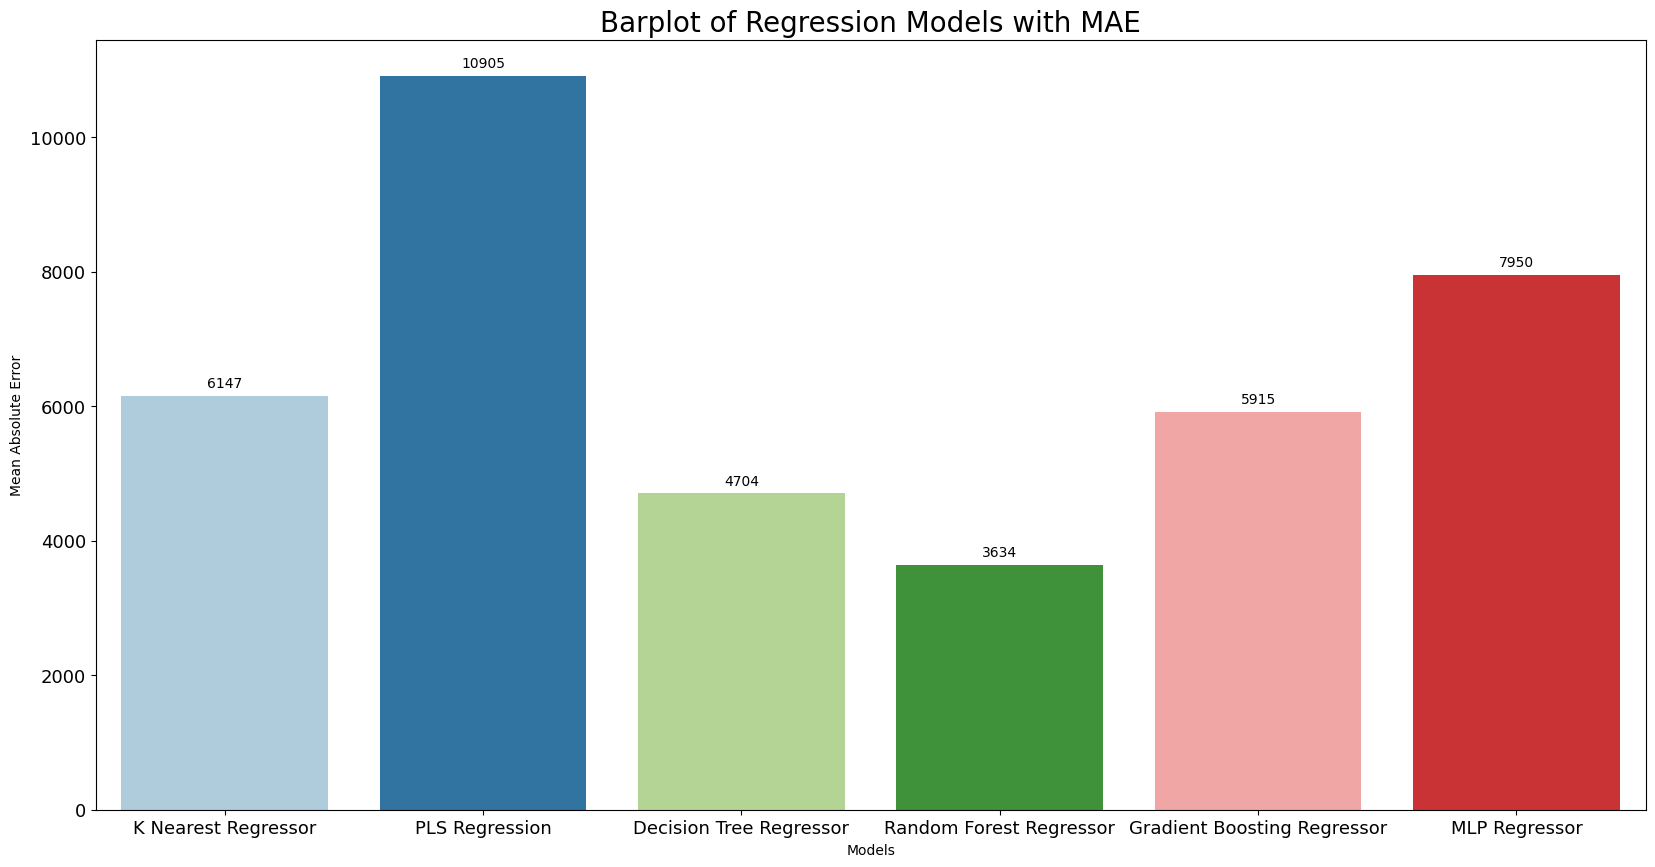

In [206]:
plt.figure(figsize=(20,10))
splot = sns.barplot(data=model_dataframe, x='Models', y='Mean Absolute Error', palette='Paired')
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.title("Barplot of Regression Models with MAE", fontsize = 20)
plt.show()

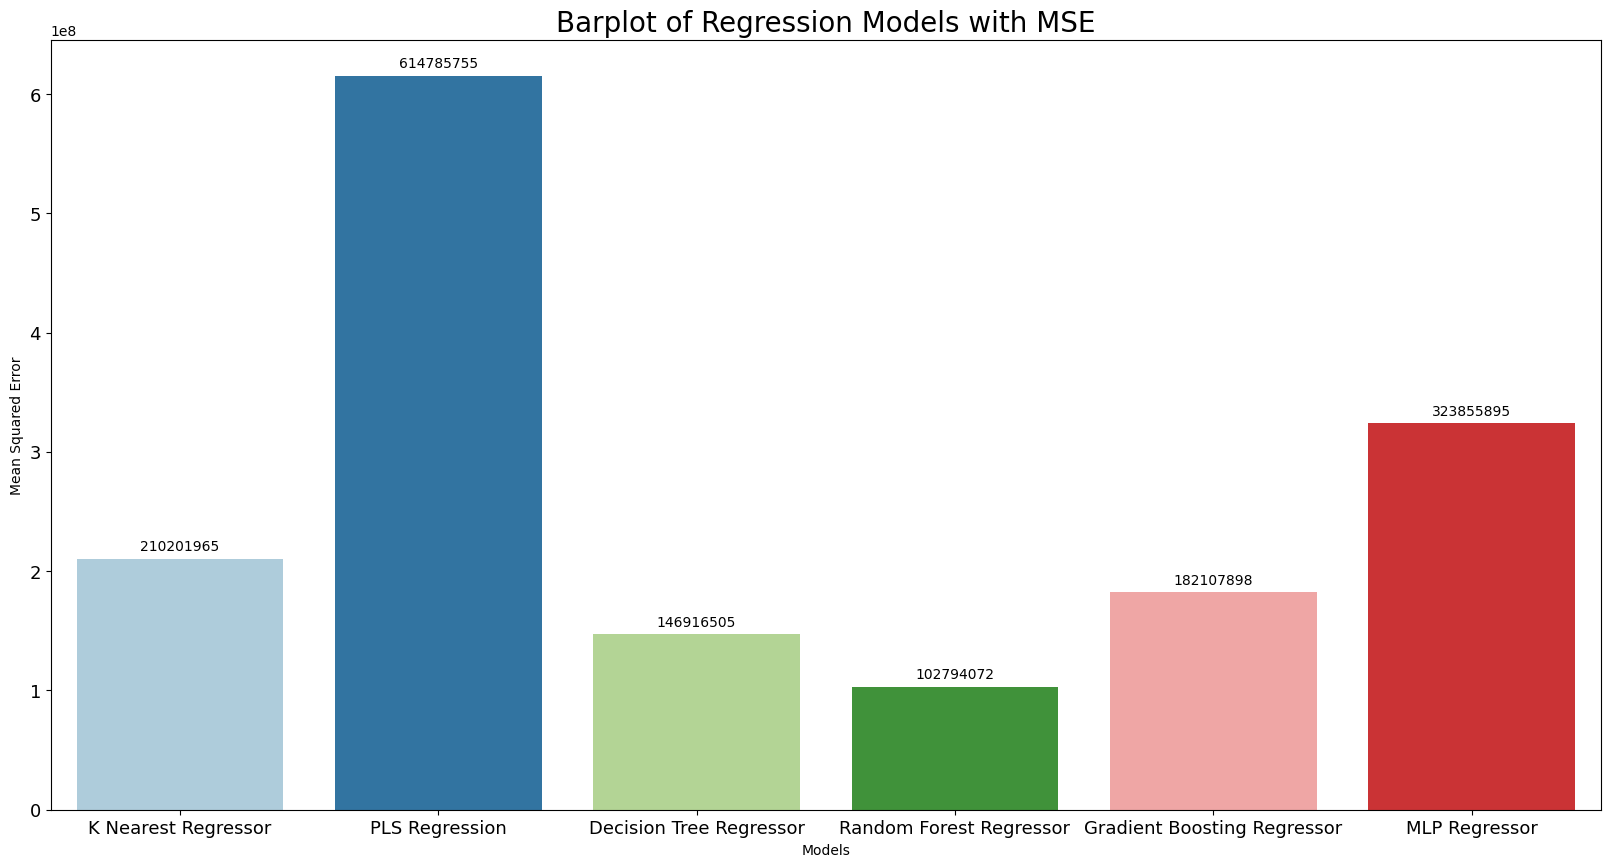

In [207]:
plt.figure(figsize=(20,10))
splot = sns.barplot(data=model_dataframe, x='Models', y='Mean Squared Error', palette='Paired')
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.title("Barplot of Regression Models with MSE", fontsize = 20)
plt.show()

# 4b) Data Manipulation + Machine Learning w/k-Fold

## Data Manipulation

In [239]:
frame = data.copy()

In [240]:
shuffled_data = shuffle(frame, random_state=1)
X = shuffled_data.drop('Price', axis=1)
y = shuffled_data['Price']

In [241]:
kf = KFold(n_splits=5, shuffle=True,random_state=1)

In [242]:
target_encoder = TargetEncoder()
one_hot_encoder = OneHotEncoder()

In [243]:
target_encoding_features = ['Make', 'Model', 'Trim', 'Color']
one_hot_encoding_features = ['Transmission', 'Fuel_Type', 'Drive_Type']

## Machine Learning

In [244]:
mse = []
mae = []

In [245]:
def train_evaluate(model,X_train,y_train,X_test,mse,mae):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse.append(int(mean_squared_error(y_pred, y_test)))
    mae.append(int(mean_absolute_error(y_pred, y_test)))

In [246]:
model_dict = {
    'knn' : KNeighborsRegressor(),
    'pls' : PLSRegression(),
    'dt' : DecisionTreeRegressor(),
    'rf' : RandomForestRegressor(),
    'gb' : GradientBoostingRegressor(),
    'mlp' : MLPRegressor(hidden_layer_sizes=50, alpha=0.001, solver='lbfgs', learning_rate='adaptive')
}

In [247]:
results = {model_name: {'mae': [], 'mse': []} for model_name in model_dict.keys()}

In [248]:
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    X_train[target_encoding_features] = target_encoder.fit_transform(X_train[target_encoding_features], y_train)
    X_test[target_encoding_features] = target_encoder.transform(X_test[target_encoding_features])

    one_hot_encoded_output_train = one_hot_encoder.fit_transform(X_train[one_hot_encoding_features])
    one_hot_encoded_output_test = one_hot_encoder.transform(X_test[one_hot_encoding_features])
    X_train = pd.concat([X_train, one_hot_encoded_output_train], axis=1)
    X_test = pd.concat([X_test, one_hot_encoded_output_test], axis=1)  
    X_train = X_train.drop(['Transmission', 'Fuel_Type', 'Drive_Type'],axis=1)
    X_test = X_test.drop(['Transmission', 'Fuel_Type', 'Drive_Type'],axis=1)
    
    for model_name, metrics in results.items():
        model = model_dict[model_name]
        train_evaluate(model,X_train,y_train,X_test,results[model_name]['mse'], results[model_name]['mae'])

In [249]:
results_dataframe = pd.DataFrame(results)

In [250]:
results_dataframe

,knn,pls,dt,rf,gb,mlp
mae,"[6052, 6104, 6001, 6313, 6609]","[13021, 12903, 12716, 12959, 13338]","[4882, 4886, 5071, 5131, 5611]","[3623, 3688, 3861, 3968, 4170]","[5921, 6027, 6099, 6387, 6460]","[7999, 8011, 8164, 8204, 8565]"
mse,"[230123669, 235781931, 224402382, 285185630, 5...","[687919683, 706078523, 672606402, 667032140, 9...","[174893894, 178103990, 202748586, 220088745, 5...","[99598274, 115051553, 127085788, 184501456, 38...","[183096205, 216709055, 209595905, 267630082, 4...","[318212336, 333512814, 345667441, 357713444, 6..."


# 5) Predict 

Best Model: 
- Random Forest Regressor: 3598 MAE; 99988885 MSE
- target encoding on make model trim color
- onehot encoding on transmission fuel_type drive_type
- no scaling on Mileage, Engine_Size, Gas_Mileage, Latitude, Longitude
- coordinates in degrees

In [208]:
new_car = pd.DataFrame({
    'Make':['Audi'],
    'Model':['A8'],
    'Age':['2023'],
    'Trim':['quattro 55 TFSI'],
    'Mileage':7800,
    'Color':['Vesuvius Gray Metallic'],
    'Engine_Size':6,
    'Gas_Mileage':22,
    'Location':['08550'],
    'Transmission':['Automatic'],
    'Fuel_Type':['Gas'],
    'Drive_Type':['AWD'],
})

# replace year with age
current_year = datetime.datetime.now().year
new_car['Age'] = current_year - new_car['Age'].astype(int)

# get coordinates from zip code
nomi = pgeocode.Nominatim('us')
location = nomi.query_postal_code(new_car['Location'][0])
new_car['Latitude'] = location.latitude 
new_car['Longitude'] = location.longitude 
new_car = new_car.drop(columns=['Location'])

# target encoding
new_car['Make'] = make_encoder.transform(new_car['Make'])
new_car['Model'] = model_encoder.transform(new_car['Model'])
new_car['Trim'] = trim_encoder.transform(new_car['Trim'])
new_car['Color'] = color_encoder.transform(new_car['Color'])

# one hot encoding
categorical_features = new_car[['Transmission', 'Fuel_Type', 'Drive_Type']]
one_hot_encoded_new_car = encoder.transform(categorical_features)

one_hot_encoded_new_car_df = pd.DataFrame(one_hot_encoded_new_car, columns=encoder.get_feature_names_out())
new_car = pd.concat([new_car.drop(columns=['Transmission', 'Fuel_Type', 'Drive_Type']), one_hot_encoded_new_car_df], axis=1)



In [209]:
new_car

,Make,Model,Age,Trim,Mileage,Color,Engine_Size,Gas_Mileage,Latitude,Longitude,...,Transmission_3,Fuel_Type_1,Fuel_Type_2,Fuel_Type_3,Fuel_Type_4,Fuel_Type_5,Fuel_Type_6,Drive_Type_1,Drive_Type_2,Drive_Type_3
0,53526.658031,47367.575434,1,65833.474127,7800,36174.928045,6,22,40.2669,-74.6511,...,0,1,0,0,0,0,0,0,1,0


In [210]:
predicted_price = rf.predict(new_car)
print(predicted_price)

[72489.52]


# 6) Export Required Information

## Export Best Model

In [211]:
joblib.dump(rf, 'random_forest_model.pkl')

['random_forest_model.pkl']

## Export Makes to Models

In [227]:
makes_to_models = data.groupby('Make')['Model'].apply(lambda x: sorted(set(x))).to_dict()

In [228]:
print(makes_to_models)

{'AMC': ['Eagle 30'], 'Acura': ['CL', 'ILX', 'Integra', 'Legend', 'MDX', 'NSX', 'RDX', 'RL', 'RLX', 'RSX', 'SLX', 'TL', 'TLX', 'TSX', 'TSX Sport Wagon', 'ZDX'], 'Alfa Romeo': ['4C', 'GTV6', 'Giulia', 'Spider', 'Stelvio', 'Tonale'], 'Aston Martin': ['DB11', 'DB12', 'DB9', 'DBS', 'DBX', 'Rapide AMR', 'Rapide S', 'V12 Vanquish', 'V12 Vantage', 'V8 Vantage', 'Vanquish', 'Vantage', 'Virage'], 'Audi': ['4000', 'A3', 'A3 Sportback e-tron', 'A4', 'A4 allroad', 'A5', 'A5 Sportback', 'A6', 'A6 allroad', 'A7', 'A8', 'Allroad', 'Cabriolet', 'Q3', 'Q4 e-tron', 'Q4 e-tron Sportback', 'Q5', 'Q5 Hybrid', 'Q5 Sportback', 'Q7', 'Q8', 'Q8 e-tron', 'Q8 e-tron Sportback', 'R8', 'RS 3', 'RS 4', 'RS 5', 'RS 5 Sportback', 'RS 6 Avant', 'RS 7', 'RS Q8', 'RS6', 'S3', 'S4', 'S5', 'S5 Sportback', 'S6', 'S7', 'S8', 'SQ5', 'SQ5 Sportback', 'SQ7', 'SQ8', 'SQ8 e-tron', 'SQ8 e-tron Sportback', 'TT', 'TT RS', 'TTS', 'e-tron', 'e-tron GT', 'e-tron Sportback'], 'BMW': ['1 Series', '2 Series', '3 Series', '4 Series', '5 S

In [229]:
with open('dropdown_info/makes_to_models.json', 'w') as f:
    json.dump(makes_to_models, f, indent=4)

## Export Makes and Models to Trims

In [230]:
makes_models_trims = data.groupby(['Make', 'Model'])['Trim'].apply(lambda x: sorted(set(x))).to_dict()

In [231]:
print(makes_models_trims)

{('AMC', 'Eagle 30'): ['Base'], ('Acura', 'CL'): ['2.3 Premium', '3.2', '3.2 Type-S'], ('Acura', 'ILX'): ['2.0L', '2.0L w/Tech', '2.4L w/Premium', '8-Spd AT w/ Premium Package', 'Base', 'Premium & A-SPEC Packages', 'Premium Package', 'Premium Pkg Sedan 4D', 'Sedan 4D', 'Standard', 'Technology & A-SPEC Pkgs Sedan 4D', 'Technology Package', 'Technology Pkg Sedan 4D', 'Technology/A-Spec Package', 'w/Premium', 'w/Premium/A-SPEC Package', 'w/Premium/A-SPEC Pkg', 'w/Special Edition', 'w/Tech', 'w/Technology/A-SPEC Package', 'with Premium and A-Spec Package'], ('Acura', 'Integra'): ['Base', 'Type S', 'w/A-SPEC', 'w/Tech w/A-SPEC'], ('Acura', 'Legend'): ['Base', 'GS', 'L'], ('Acura', 'MDX'): ['Base', 'SH-AWD', 'SH-AWD Sport Utility 4D', 'SH-AWD w/A-SPEC', 'SH-AWD w/Advance', 'SH-AWD w/Advance w/RES', 'SH-AWD w/Power Tailgate w/Tech', 'SH-AWD w/Tech', 'SH-AWD w/Tech w/RES', 'Technology Package', 'Touring w/Navi w/RES', 'w/Tech'], ('Acura', 'NSX'): ['Base', 'NSX-T', 'SH-AWD Sport Hybrid', 'SH-AW

In [232]:
json_compatible = {f"{make}_{model}": trims for (make, model), trims in makes_models_trims.items()}

In [233]:
with open('dropdown_info/makes_models_to_trims.json', 'w') as f:
    json.dump(json_compatible, f, indent=4)

## Export Makes and Models to Colors

In [234]:
makes_models_colors = data.groupby(['Make', 'Model'])['Color'].apply(lambda x: sorted(set(x))).to_dict()

In [235]:
print(makes_models_colors)

{('AMC', 'Eagle 30'): ['Brown'], ('Acura', 'CL'): ['Black', 'Naples Gold Metallic', 'Red', 'San Marino Red', 'White'], ('Acura', 'ILX'): ['Apex Blue Pearl', 'Basque Red Pearl Ii', 'Bellanova White Pearl', 'Black', 'Blue', 'Burgundy', 'Crystal Black Pearl', 'Gray', 'Lunar Silver Metallic', 'Majestic Black Pearl', 'Modern Steel Metallic', 'Pearl White', 'Performance Red Pearl', 'Platinum White Pearl', 'Polished Metal Metallic', 'Silver', 'Slate Silver Metallic', 'Unknown', 'Whi', 'White', 'nan'], ('Acura', 'Integra'): ['Apex Blue Pearl', 'Black', 'Gray', 'Green', 'Liquid Carbon Metallic', 'Lunar Silver Metallic', 'Majestic Black Pearl', 'Performance Red Pearl', 'Platinum White Pearl', 'Silver', 'Unknown', 'nan'], ('Acura', 'Legend'): ['Charcoal', 'Gold', 'Green', 'White'], ('Acura', 'MDX'): ['Aspen White Pearl', 'Billet Silver Metallic', 'Black', 'Blue', 'Brown', 'Burgundy', 'Crystal Black Pearl', 'Fathom Blue Pearl', 'Graphite Luster Metallic', 'Gray', 'Grigio Metallic', 'Gunmetal Metal

In [236]:
json_compatible = {f"{make}_{model}": colors for (make, model), colors in makes_models_colors.items()}

In [237]:
with open('dropdown_info/makes_models_to_colors.json', 'w') as f:
    json.dump(json_compatible, f, indent=4)

In [238]:
joblib.dump(make_encoder, 'encoders/make_encoder.pkl')
joblib.dump(model_encoder, 'encoders/model_encoder.pkl')
joblib.dump(trim_encoder, 'encoders/trim_encoder.pkl')
joblib.dump(color_encoder, 'encoders/color_encoder.pkl')
joblib.dump(encoder, 'encoders/onehotencoder.pkl')

['encoders/onehotencoder.pkl']